# Proyecto Final

## Importación de la data

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Import libreries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *

Ideas: 1. predicción de la cotización de las 5 empresas con la mayor capitalización del nasdaq? FAANG para los sigueintes años 2025 y 2026 me gustaría llegar hasta el 2030 pero aun no se como saldrá el asunto
Facebook, Amazon, Apple, Netflix y Google.

In [6]:
aapl_data = download_stock_data("AAPL")
#aapl_data_clean = preprocess_data(aapl_data)
#aapl_predictions = model_stock_price(aapl_data_clean)

# Luego se puede iterar para las demás empresas:
companies = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Amazon': 'AMZN',
    'Alphabet': 'GOOGL',
    'NVIDIA': 'NVDA'
}

# for company, ticker in companies.items():
#     data = download_stock_data(ticker)
#     data_clean = preprocess_data(data)
#     predictions = model_stock_price(data_clean)
#     mae, rmse = evaluate_model(predictions, data['Close'])
#     print(f'{company} - MAE: {mae}, RMSE: {rmse}')

## Cleaned data

In [7]:
# Normalizar los nombres de las columnas
apple_data = normalizar_nombres_columnas(aapl_data)

In [8]:
data_report = data_quality_report(aapl_data)

----- Informe de Calidad de Datos -----

Valores nulos por columna:
 open            0
high            0
low             0
close           0
volume          0
dividends       0
stock_splits    0
dtype: int64

Número de filas duplicadas: 0

Tipos de datos:
 open            float64
high            float64
low             float64
close           float64
volume            int64
dividends       float64
stock_splits    float64
dtype: object

Descripción estadística de las columnas numéricas:
               open         high          low        close        volume  \
count  2517.000000  2517.000000  2517.000000  2517.000000  2.517000e+03   
mean     90.056359    91.019781    89.148201    90.128031  1.200761e+08   
std      63.178850    63.840801    62.552072    63.230574  6.903220e+07   
min      20.642059    21.025084    20.520493    20.720032  2.404830e+07   
25%      33.456220    33.591225    33.311483    33.446907  7.369590e+07   
50%      56.870857    57.490156    56.677320    57.059547 

### Agregamos columnas

Columna date fuera del indice

In [9]:
# Asegurarse de que el índice actual es un DateTimeIndex
apple_data.index = pd.to_datetime(apple_data.index)  # Convertir el índice en formato datetime si aún no lo es

# Añadir la columna 'date' que replica el índice actual
apple_data['date'] = apple_data.index

Agregar retornos logarítmicos (Log Returns):

Los retornos logarítmicos pueden ser útiles para predecir el comportamiento del precio a futuro, ya que tienden a estabilizar la varianza a lo largo del tiempo.

In [10]:
apple_data['log_return'] = np.log(apple_data['close'] / apple_data['close'].shift(1))
apple_data.dropna(inplace=True)  # Eliminar filas con NaN generados por shift

Volatilidad histórica:

La volatilidad es un indicador clave en los mercados financieros y podría ayudarte a capturar la fluctuación de precios a lo largo del tiempo.

In [11]:
apple_data['volatility'] = apple_data['log_return'].rolling(window=30).std() * np.sqrt(30)
apple_data.dropna(inplace=True)  # Eliminar filas con NaN

Media móvil (Moving Average):

Incluir medias móviles de 50 días, 100 días o más largas puede ayudarte a capturar tendencias más generales.

In [12]:
apple_data['ma50'] = apple_data['close'].rolling(window=50).mean()
apple_data['ma100'] = apple_data['close'].rolling(window=100).mean()
apple_data.dropna(inplace=True)  # Eliminar filas con NaN

Relación entre volumen y precio (Volume-to-Price Ratio):

La relación entre el volumen y el precio puede ser un buen indicador de movimientos significativos en el mercado.

In [13]:
apple_data['volume_to_price'] = apple_data['volume'] / apple_data['close']

In [14]:
apple_data.dropna(inplace=True)
# # 1. Eliminar columnas innecesarias
# df = apple_data.drop(columns=['stock_splits', 'stock_splits'])

In [15]:
# Preprocesar los datos (ajuste por stock splits, dividendos, normalización, estandarización)
apple_adjusted, apple_normalized, apple_standardized = preprocess_data_dos(apple_data)

Preprocesamiento completo. Se han generado versiones con los datos ajustados, normalizados y estandarizados.


In [16]:
apple_adjusted.columns
apple_normalized.columns
apple_standardized.columns

Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
       'date', 'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price',
       'dividend_return'],
      dtype='object')

## EDA Análisis Exploratorio de Datos

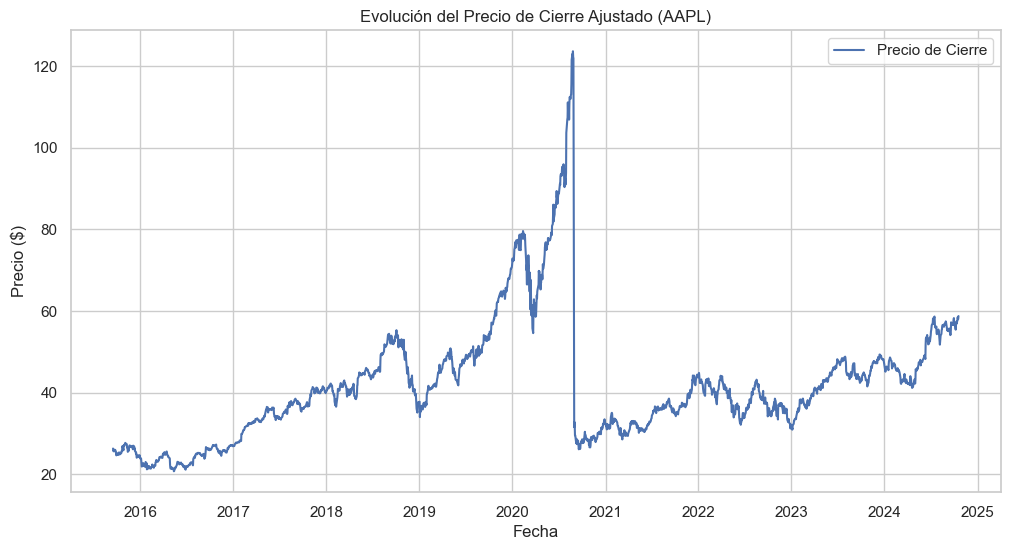

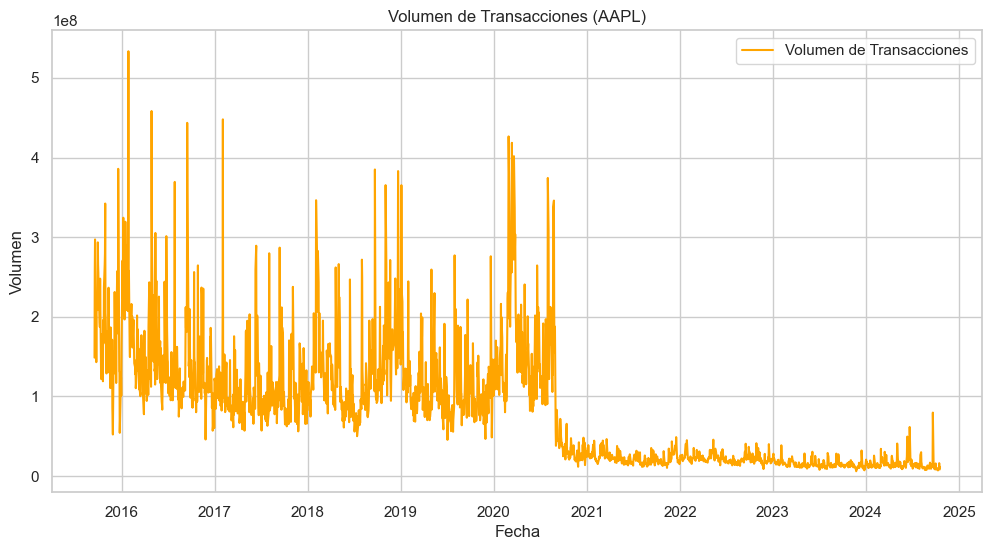

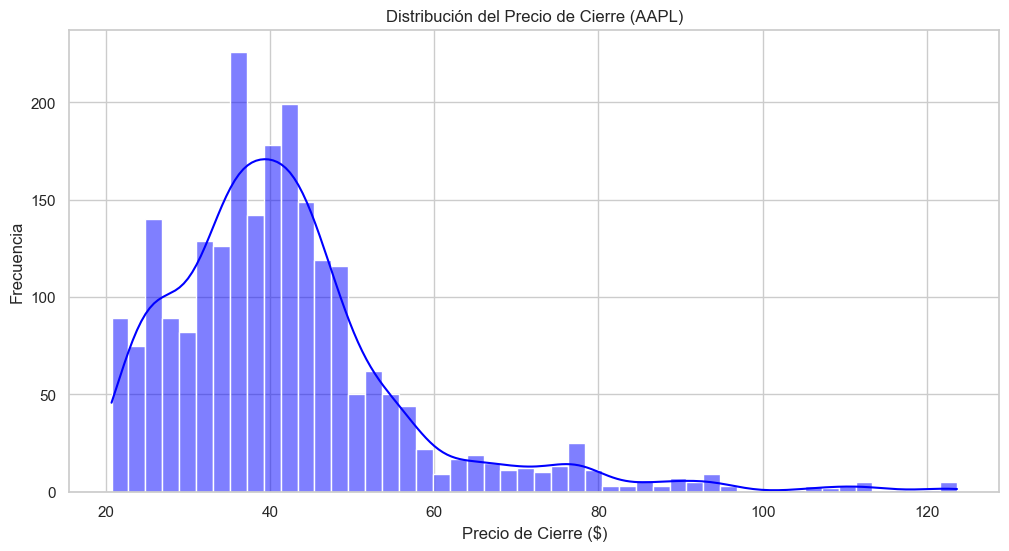

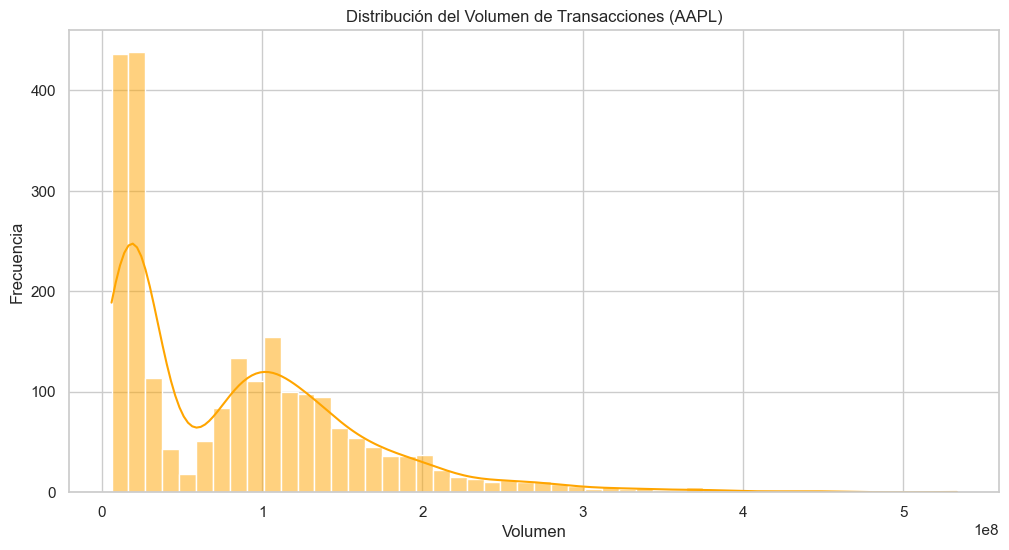

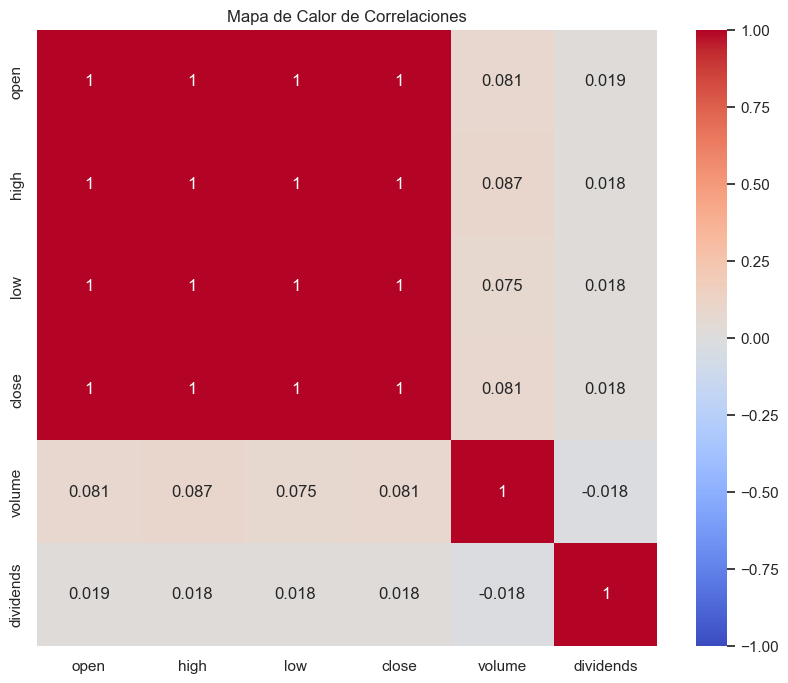

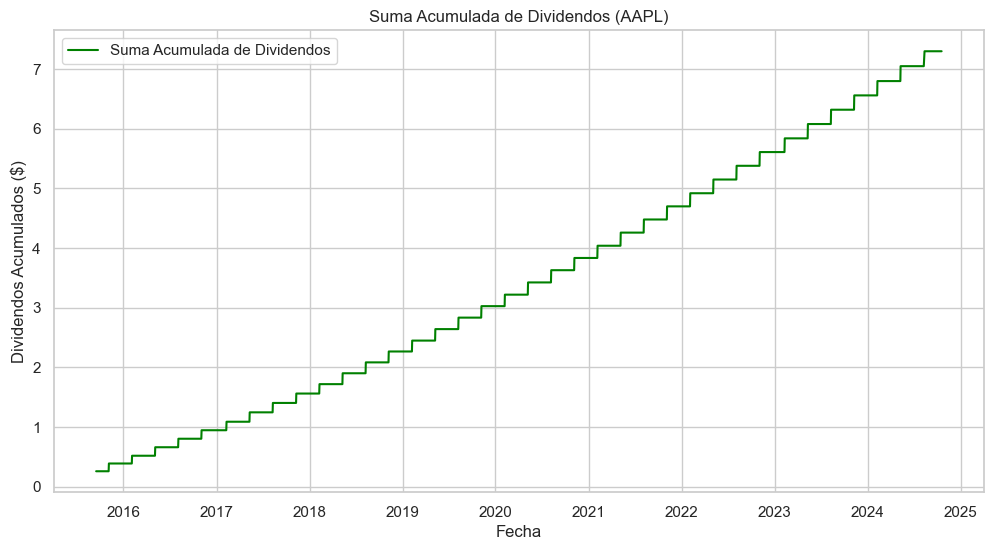

EDA completado.


In [17]:
#Probaremos los modelos tanto con los datos sin normalizar como con los datos normalizados y estandarizados, para comparar su rendimiento.
# Realizamos el EDA en los datos ajustados
perform_eda(apple_adjusted)

### normalized

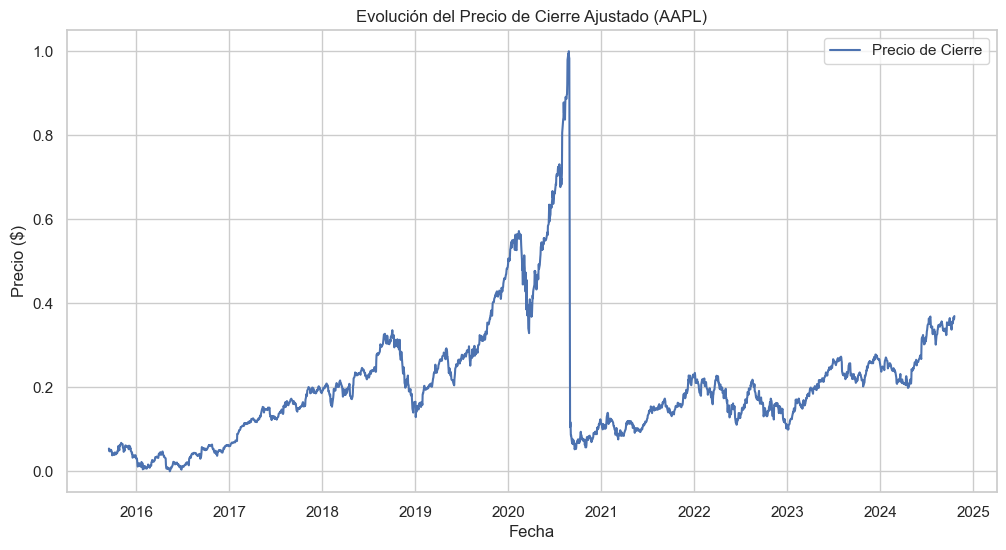

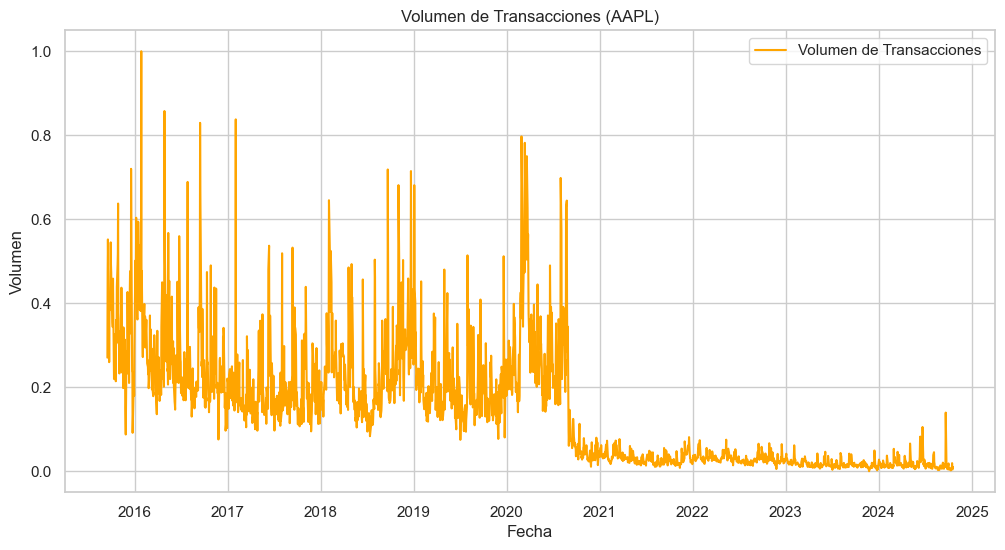

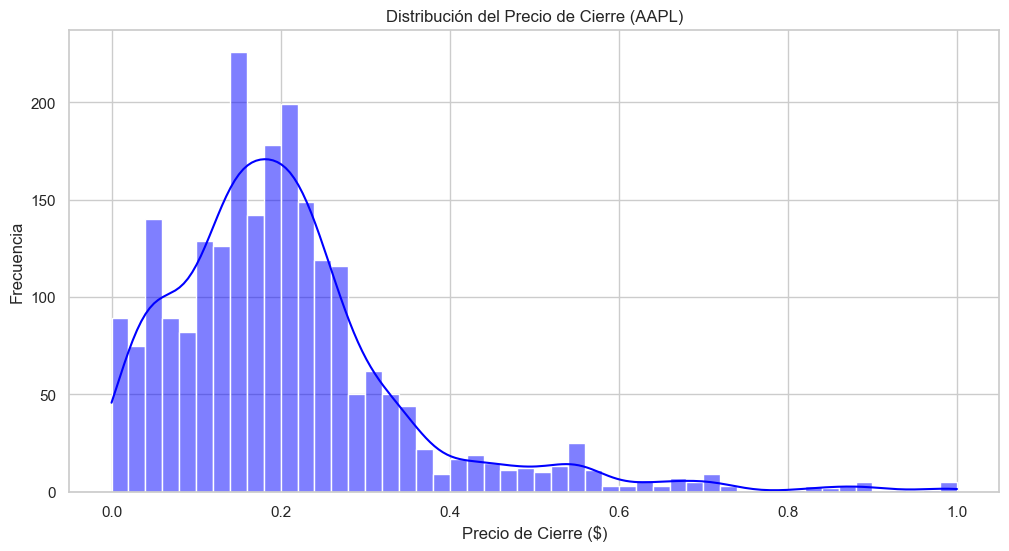

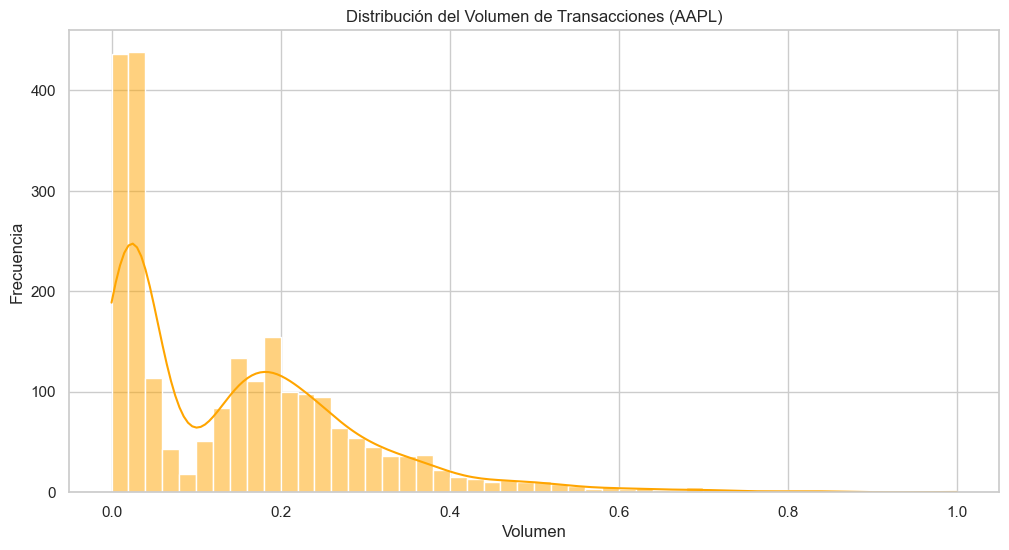

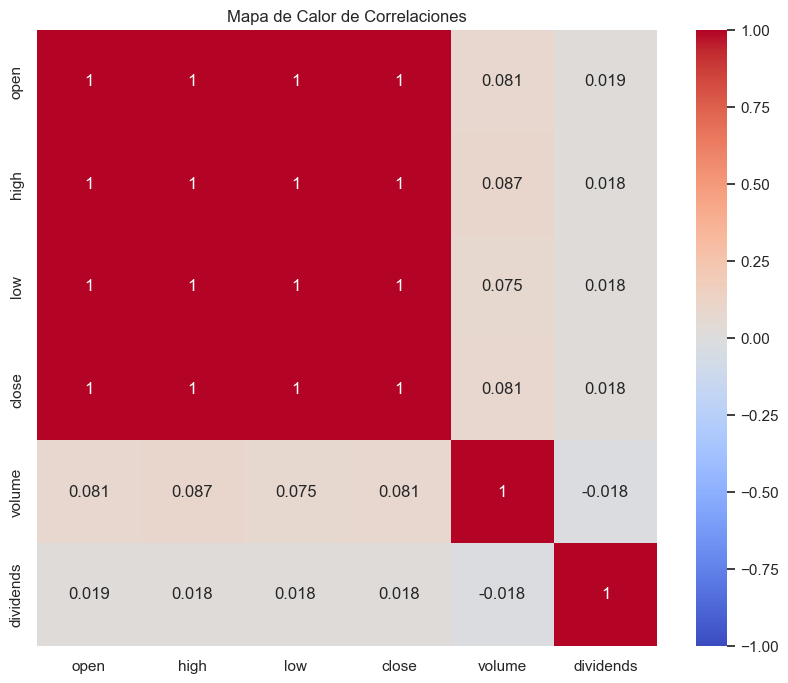

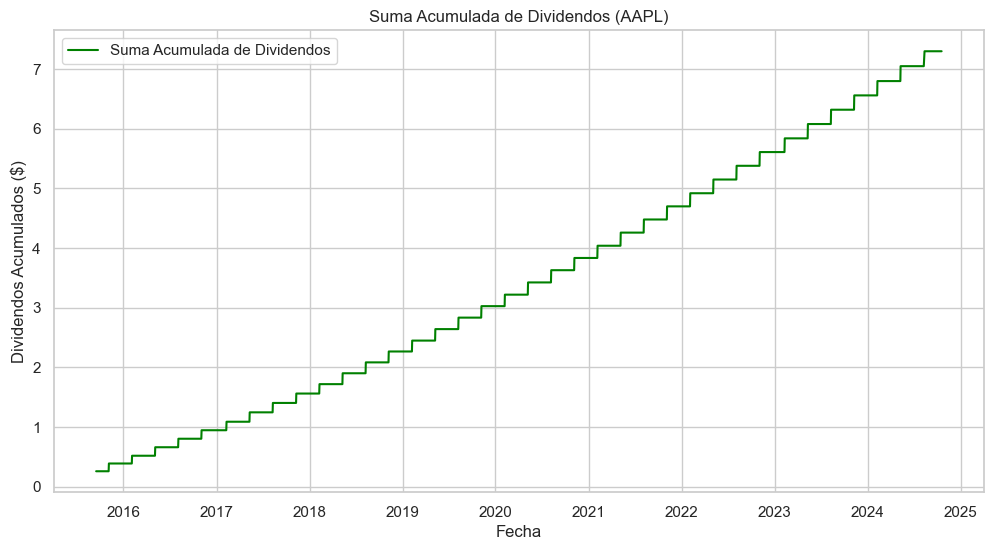

EDA completado.


In [18]:
perform_eda(apple_normalized)

### standardized

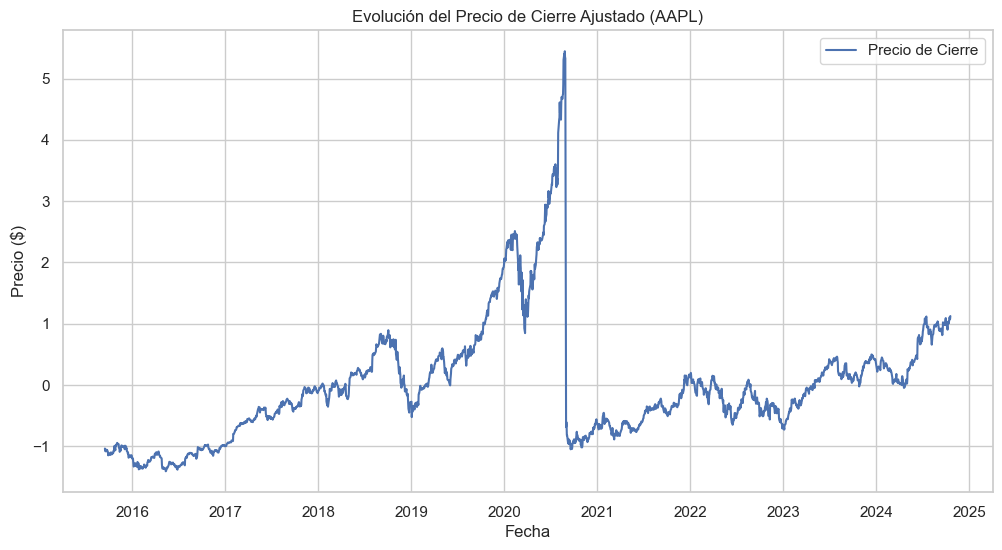

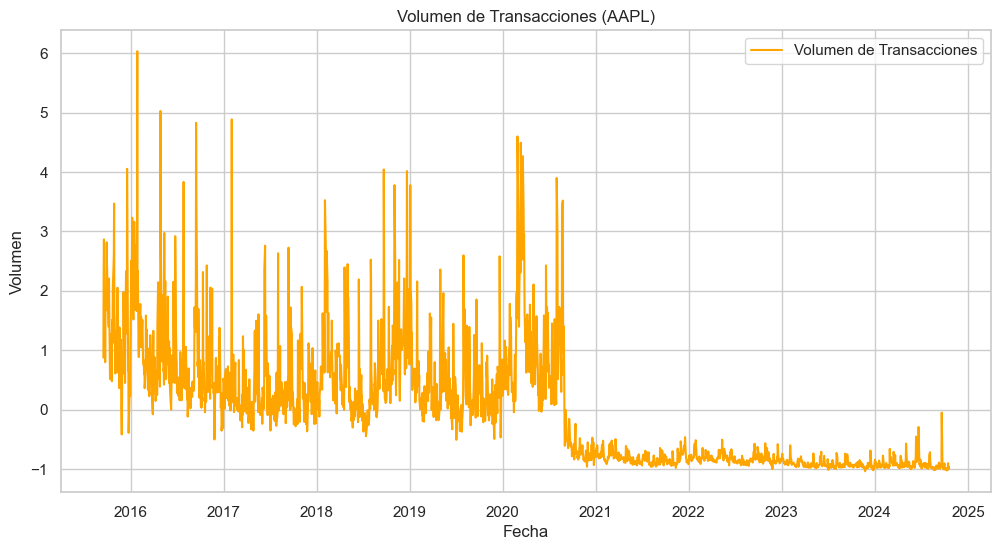

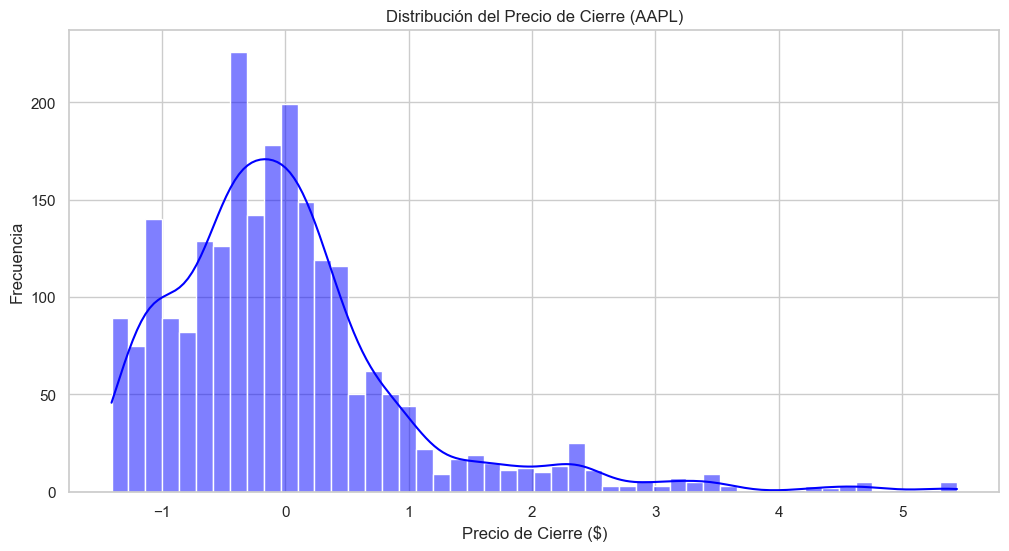

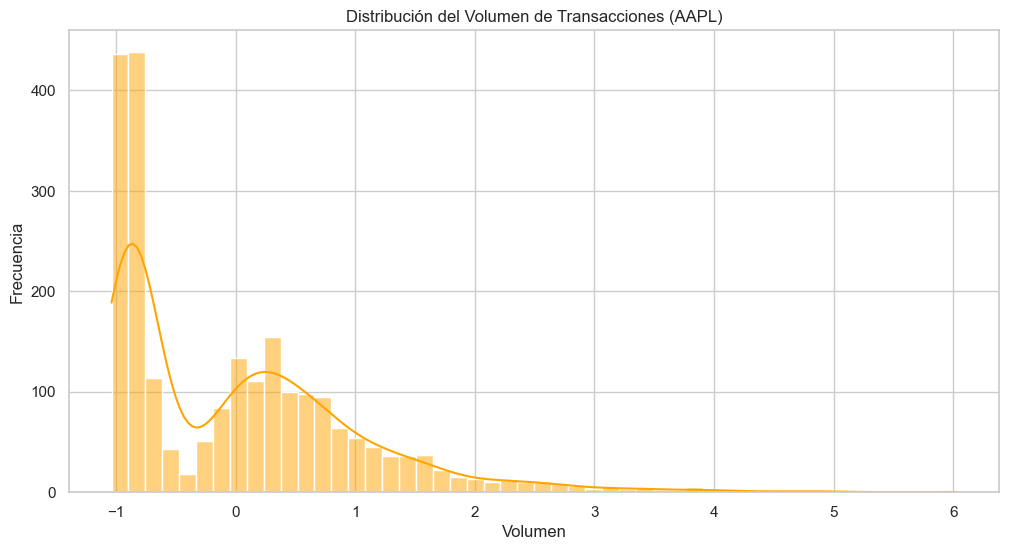

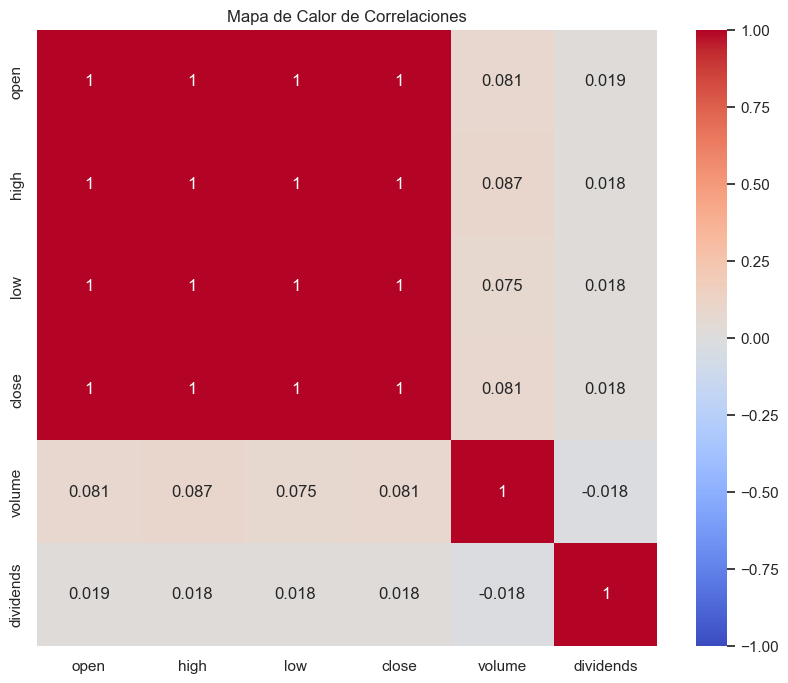

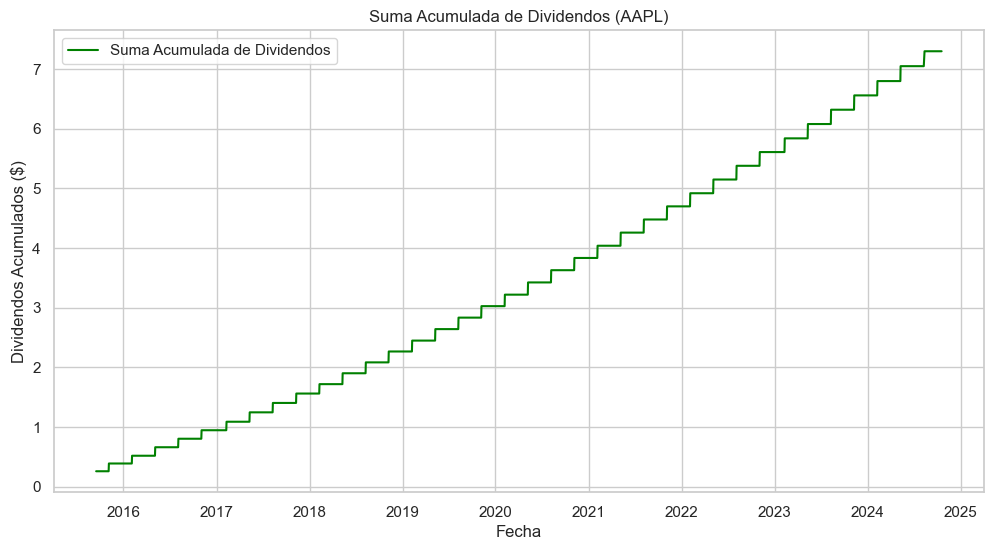

EDA completado.


In [19]:
perform_eda(apple_standardized)

## Modelos

Para observar las pruebas con los modelos dirijase al archivo draft

### Regresion lineal

C:\Users\danny\AppData\Local\Temp\ipykernel_27256\931244382.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start='2024-10-31', periods=72, freq='M')
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does

         Date  Predicted Close
0  2024-10-31        58.235088
1  2024-11-30        58.315833
2  2024-12-31        58.181061
3  2025-01-31        58.277904
4  2025-02-28        58.344085
..        ...              ...
67 2030-05-31        58.281338
68 2030-06-30        58.281338
69 2030-07-31        58.281338
70 2030-08-31        58.281338
71 2030-09-30        58.281338

[72 rows x 2 columns]


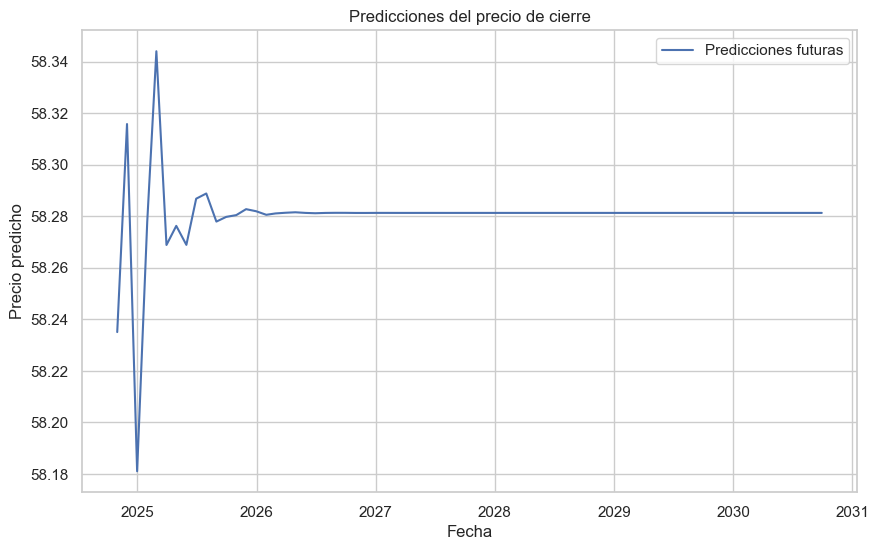

In [20]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Función para crear características de retardos
def create_lagged_features(df, target, lags=5):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target].shift(lag)
    df.dropna(inplace=True)  # Eliminamos valores NaN
    return df

# Suponiendo que 'apple_adjusted' es el dataframe original con las características originales
# Aplicar la función de retardos en 'close'
df_lagged = create_lagged_features(apple_adjusted, 'close', lags=5)

# Seleccionamos las columnas para entrenar el modelo
X_train = df_lagged[['open', 'high', 'low', 'volume', 'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price']]
y_train = df_lagged['close']

# Entrenar el modelo de regresión lineal
model_lin_reg = LinearRegression()
model_lin_reg.fit(X_train, y_train)

# Definir la última ventana de observaciones (últimas 'window_size' filas de X_train)
window_size = 5
last_observation = X_train.iloc[-window_size:].values

# Generar las fechas futuras para predicción
future_dates = pd.date_range(start='2024-10-31', periods=72, freq='M')

# Inicializar la lista para almacenar predicciones futuras
future_predictions = []

# Realizamos las predicciones iterativas usando una ventana deslizante
for date in future_dates:
    # Hacer la predicción usando la media móvil de las últimas n observaciones
    mean_window = np.mean(last_observation, axis=0).reshape(1, -1)
    predicted_value = model_lin_reg.predict(mean_window)[0]
    
    # Guardar la predicción
    future_predictions.append(predicted_value)
    
    # Actualizar la ventana deslizante con la nueva predicción
    next_observation = np.append(mean_window[:, :-1], [[predicted_value]], axis=1)
    last_observation = np.vstack([last_observation[1:], next_observation])

# Crear un DataFrame para las fechas futuras y sus predicciones
df_future = pd.DataFrame({
    'Date': future_dates,
    'Predicted Close': future_predictions
})

# Mostrar el DataFrame con las predicciones futuras
print(df_future)

# Graficar las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(df_future['Date'], df_future['Predicted Close'], label='Predicciones futuras')
plt.title('Predicciones del precio de cierre')
plt.xlabel('Fecha')
plt.ylabel('Precio predicho')
plt.legend()
plt.show()


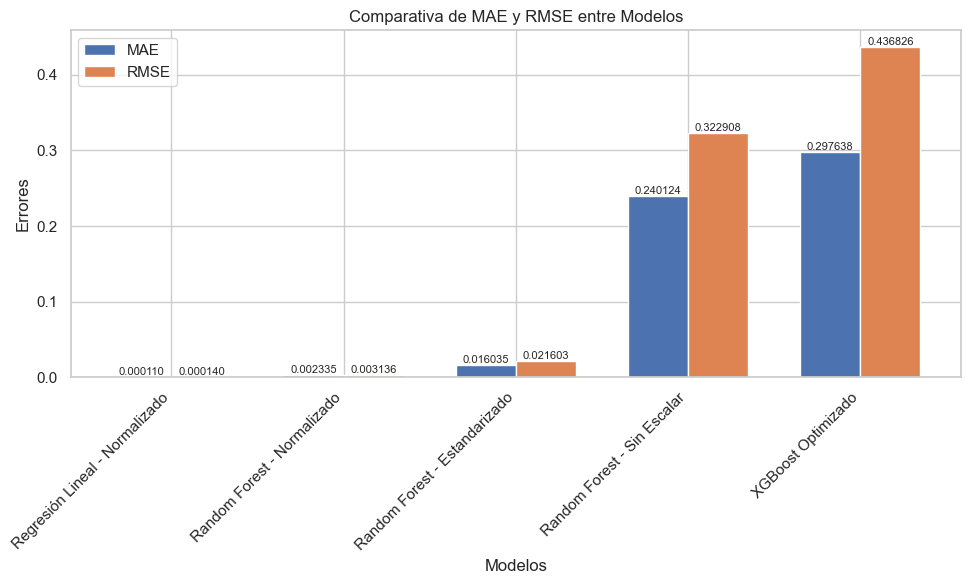

,MAE,RMSE,R²
Regresión Lineal - Normalizado,0.000110,0.000140,0.99727
Random Forest - Normalizado,0.002335,0.003136,0.99729
Random Forest - Estandarizado,0.016035,0.021603,0.99726
Random Forest - Sin Escalar,0.240124,0.322908,0.99729
XGBoost Optimizado,0.297638,0.436826,0.99551


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Nuevos resultados en orden
results = {
    "Regresión Lineal - Normalizado": {"MAE": 0.000109874, "RMSE": 0.000140386, "R²": 0.99727},
    "Random Forest - Normalizado": {"MAE": 0.002335423, "RMSE": 0.003136368, "R²": 0.99729},
    "Random Forest - Estandarizado": {"MAE": 0.016035116, "RMSE": 0.021603375, "R²": 0.99726},
    "Random Forest - Sin Escalar": {"MAE": 0.240124092, "RMSE": 0.322908338, "R²": 0.99729},
    "XGBoost Optimizado": {"MAE": 0.297637639, "RMSE": 0.436825841, "R²": 0.99551}
}

# Convertir a DataFrame
df_results = pd.DataFrame(results).T

# Ordenar por MAE
df_results = df_results.sort_values(by="MAE")

# Graficar comparativa
fig, ax = plt.subplots(figsize=(10, 6))

# Ancho de las barras
bar_width = 0.35

# Posiciones
indices = np.arange(len(df_results))

# Crear barras para MAE y RMSE
bars1 = ax.bar(indices, df_results["MAE"], bar_width, label='MAE')
bars2 = ax.bar(indices + bar_width, df_results["RMSE"], bar_width, label='RMSE')

# Añadir etiquetas a las barras
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    ax.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), f'{bar1.get_height():.6f}', 
            ha='center', va='bottom', fontsize=8)
    ax.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height(), f'{bar2.get_height():.6f}', 
            ha='center', va='bottom', fontsize=8)

# Configurar etiquetas y título
ax.set_xlabel('Modelos')
ax.set_ylabel('Errores')
ax.set_title('Comparativa de MAE y RMSE entre Modelos')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(df_results.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Mostrar tabla ordenada
df_results


In [22]:
import pandas as pd

# Crear un DataFrame con los resultados de los modelos
model_results = {
    'Modelo': ['Random Forest (Normalizado)', 'Random Forest (Estandarizado)', 'Random Forest (Sin Escalar)',
               'Regresión Lineal (Normalizado)', 'Regresión Lineal (Estandarizado)', 'Regresión Lineal (Sin Escalar)',
               'XGBoost Optimizado', 'Regresión Lineal 2'],
    'MAE': [0.002335423490510121, 0.016035116128674594, 0.2401240916439539,
            0.0017635423914050517, 0.012090196060171617, 0.181509810839558,
            0.29763763869356014, 0.04412283961931121],
    'RMSE': [0.0031363681480837025, 0.02160337525691731, 0.3229083380666715,
             0.0022752541203950186, 0.015598302902360467, 0.23417693136362294,
             0.43682584115746387, 0.057311128116010725],
    'R²': [0.9972895803301488, 0.9972639072838042, 0.9972878569716966,
           0.9985735968470549, 0.9985735968470549, 0.9985735968425292,
           0.9955125948271191, 0.9986325840140575]
}

# Crear el DataFrame
df_models = pd.DataFrame(model_results)

# Ordenar los modelos por MAE de mejor a peor
df_models_sorted = df_models.sort_values(by='MAE').reset_index(drop=True)

# Mostrar el DataFrame

df_models_sorted


,Modelo,MAE,RMSE,R²
0,Regresión Lineal (Normalizado),0.001764,0.002275,0.998574
1,Random Forest (Normalizado),0.002335,0.003136,0.997290
2,Regresión Lineal (Estandarizado),0.012090,0.015598,0.998574
3,Random Forest (Estandarizado),0.016035,0.021603,0.997264
4,Regresión Lineal 2,0.044123,0.057311,0.998633
5,Regresión Lineal (Sin Escalar),0.181510,0.234177,0.998574
6,Random Forest (Sin Escalar),0.240124,0.322908,0.997288
7,XGBoost Optimizado,0.297638,0.436826,0.995513


### Predicción hasta 2030

In [23]:
import pandas as pd

# Supongamos que tienes un DataFrame original llamado 'df_original' con las columnas necesarias
def create_lagged_features(df, target, lags=5):  # Crea las características retardadas
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target].shift(lag)
    df.dropna(inplace=True)  # Eliminar NaN resultante de los retardos
    return df

# Crear df_lagged con las características retardadas
df_lagged = create_lagged_features(apple_normalized, 'close', lags=5)  # 'close' es la columna objetivo


In [24]:
from sklearn.linear_model import LinearRegression

# Seleccionar las columnas de entrenamiento
X_train = df_lagged[['open', 'high', 'low', 'volume', 'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price']]
y_train = df_lagged['close']

# Definir el modelo de regresión lineal
model_lin_reg = LinearRegression()

# Entrenar el modelo
model_lin_reg.fit(X_train, y_train)


LinearRegression()

In [25]:
import numpy as np
import pandas as pd

# Asegúrate de que las características de la última observación tengan los mismos nombres que las del entrenamiento
last_observation = X_train.iloc[-1].values
last_observation_df = pd.DataFrame([last_observation], columns=X_train.columns)

# Lista para almacenar predicciones
future_predictions = []

# Generar las fechas futuras con la corrección de 'ME' para evitar el FutureWarning
future_dates = pd.date_range(start='2024-10-31', periods=72, freq='ME')

# Hacer predicciones futuras de forma iterativa
for date in future_dates:
    predicted_value = model_lin_reg.predict(last_observation_df)[0]
    future_predictions.append(predicted_value)
    
    # Actualizar la última observación simulando los cambios con la nueva predicción
    last_observation_df = last_observation_df.shift(-1, axis=1)  # Desplazar hacia la izquierda
    last_observation_df.iloc[0, -1] = predicted_value  # Actualizar con la predicción más reciente

# Crear DataFrame con las predicciones futuras
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Close': future_predictions})

# Mostrar las primeras y últimas predicciones
print(future_df.head())
print(future_df.tail())


        Date  Predicted Close
0 2024-10-31         0.369200
1 2024-11-30        -4.692384
2 2024-12-31        11.269646
3 2025-01-31        44.072422
4 2025-02-28      5182.212434
         Date  Predicted Close
67 2030-05-31    -1.420242e+06
68 2030-06-30    -5.975567e+05
69 2030-07-31     1.804279e+06
70 2030-08-31     1.311200e+06
71 2030-09-30    -1.080033e+06


In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Supongamos que este es el modelo entrenado
model_lin_reg = LinearRegression()

# Aquí se entrena el modelo como en los pasos previos
X_train = df_lagged[['open', 'high', 'low', 'volume', 'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price']]
y_train = df_lagged['close']
model_lin_reg.fit(X_train, y_train)

# Última observación (asegúrate de que las columnas coincidan con las usadas en el entrenamiento)
last_observation = X_train.iloc[-1].values  # Última fila del entrenamiento

# Asegúrate de que 'last_observation' tiene los mismos nombres de columnas
last_observation_df = pd.DataFrame([last_observation], columns=X_train.columns)

# Lista para almacenar las predicciones
future_predictions = []

# Generar fechas futuras (corrigiendo la advertencia 'M' -> 'ME')
future_dates = pd.date_range(start='2024-10-31', periods=72, freq='ME')

# Realizar predicciones para las fechas futuras
for date in future_dates:
    # Realizar la predicción
    predicted_value = model_lin_reg.predict(last_observation_df)[0]
    future_predictions.append(predicted_value)
    
    # Simular la actualización de la última observación para la siguiente predicción
    last_observation_df = last_observation_df.shift(-1, axis=1)  # Desplazar las columnas
    last_observation_df.iloc[0, -1] = predicted_value  # Colocar la predicción más reciente

# Crear DataFrame con las fechas futuras y sus predicciones
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Close': future_predictions})

# Mostrar las primeras y últimas predicciones
print(future_df.head())
print(future_df.tail())


        Date  Predicted Close
0 2024-10-31         0.369200
1 2024-11-30        -4.692384
2 2024-12-31        11.269646
3 2025-01-31        44.072422
4 2025-02-28      5182.212434
         Date  Predicted Close
67 2030-05-31    -1.420242e+06
68 2030-06-30    -5.975567e+05
69 2030-07-31     1.804279e+06
70 2030-08-31     1.311200e+06
71 2030-09-30    -1.080033e+06


In [27]:
# Imprimir los coeficientes del modelo entrenado
print("Coeficientes del modelo:", model_lin_reg.coef_)


Coeficientes del modelo: [-5.26592079e-01  7.77894637e-01  7.42468710e-01 -3.12551898e-03
  2.60255606e-02  2.16472478e-04  5.04750445e-05 -2.43881344e-05
  1.69833481e-10]


C:\Users\danny\AppData\Local\Temp\ipykernel_27256\4079526737.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start='2024-10-31', periods=72, freq='M')
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X doe

         Date  Predicted Close
0  2024-10-31         0.364495
1  2024-11-30         0.365279
2  2024-12-31         0.363970
3  2025-01-31         0.364911
4  2025-02-28         0.365554
..        ...              ...
67 2030-05-31         0.364944
68 2030-06-30         0.364944
69 2030-07-31         0.364944
70 2030-08-31         0.364944
71 2030-09-30         0.364944

[72 rows x 2 columns]


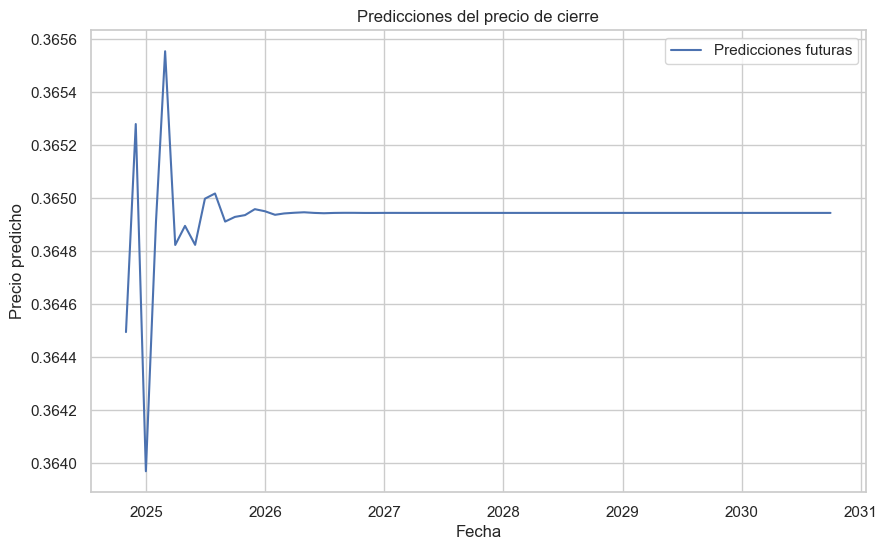

In [28]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Definimos el tamaño de la ventana deslizante
window_size = 5

# 1. Usamos las características entrenadas originalmente
# Asegúrate de que el modelo esté entrenado previamente
model_lin_reg = LinearRegression()

# Entrenamos el modelo
X_train = df_lagged[['open', 'high', 'low', 'volume', 'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price']]
y_train = df_lagged['close']
model_lin_reg.fit(X_train, y_train)

# Obtenemos la última fila de X_train como base
last_observation = X_train.iloc[-window_size:].values

# Generar las fechas futuras para predicción
future_dates = pd.date_range(start='2024-10-31', periods=72, freq='M')

# Inicializar la lista para almacenar predicciones futuras
future_predictions = []

# 2. Realizamos las predicciones iterativas usando una ventana deslizante
for date in future_dates:
    # Hacer la predicción usando la media móvil de las últimas n observaciones
    mean_window = np.mean(last_observation, axis=0).reshape(1, -1)
    predicted_value = model_lin_reg.predict(mean_window)[0]
    
    # Guardar la predicción
    future_predictions.append(predicted_value)
    
    # Actualizar la ventana deslizante con la nueva predicción
    next_observation = np.append(mean_window[:, :-1], [[predicted_value]], axis=1)
    last_observation = np.vstack([last_observation[1:], next_observation])

# Crear un DataFrame para las fechas futuras y sus predicciones
df_future = pd.DataFrame({
    'Date': future_dates,
    'Predicted Close': future_predictions
})

# Mostrar el DataFrame con las predicciones futuras
print(df_future)

# 3. Graficar las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(df_future['Date'], df_future['Predicted Close'], label='Predicciones futuras')
plt.title('Predicciones del precio de cierre')
plt.xlabel('Fecha')
plt.ylabel('Precio predicho')
plt.legend()
plt.show()


In [29]:
#Mejorar la ventana deslizante: Actualmente, estás utilizando una ventana deslizante fija para las predicciones. Podrías probar a ajustar la longitud de la ventana o a combinar varias longitudes de ventana (por ejemplo, una media móvil corta y una larga) para ver si mejora la capacidad de predicción.

Entrenamiento - MAE: 0.17776459203247436, RMSE: 0.29526162694271985
Prueba - MAE: 0.16420226201108917, RMSE: 0.2136182569788394
                        Date  Predicted Close
0  2024-10-31 00:00:00-04:00     5.873254e+01
1  2024-11-30 00:00:00-05:00     8.219248e+06
2  2024-12-31 00:00:00-05:00     8.492143e+06
3  2025-01-31 00:00:00-05:00    -5.289061e+06
4  2025-02-28 00:00:00-05:00     1.463552e+06
5  2025-03-31 00:00:00-04:00    -3.270675e+05
6  2025-04-30 00:00:00-04:00     2.212262e+05
7  2025-05-31 00:00:00-04:00     1.001725e+06
8  2025-06-30 00:00:00-04:00     3.972165e+07
9  2025-07-31 00:00:00-04:00     3.943924e+07
10 2025-08-31 00:00:00-04:00    -1.706975e+07
11 2025-09-30 00:00:00-04:00     2.136634e+07


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature 

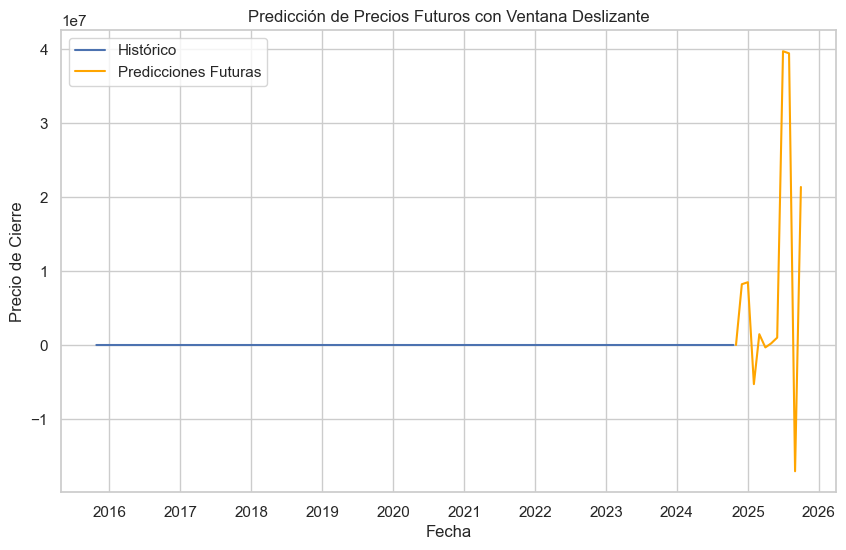

In [30]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Crear medias móviles
def add_moving_averages(df, short_window=5, long_window=20):
    df['ma_short'] = df['close'].rolling(window=short_window).mean()
    df['ma_long'] = df['close'].rolling(window=long_window).mean()
    df.dropna(inplace=True)
    return df

# 2. Crear características con retardos y las medias móviles
def create_lagged_features(df, target, lags=5):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target].shift(lag)
    df.dropna(inplace=True)
    return df

# Aplicar medias móviles y retardos
df_lagged = apple_adjusted.copy()  # Asegúrate de tener el DataFrame 'apple_adjusted'
df_lagged = add_moving_averages(df_lagged)
df_lagged = create_lagged_features(df_lagged, 'close', lags=5)

# 3. Definir las características y el target (incluyendo medias móviles)
features = ['open', 'high', 'low', 'volume', 'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price', 'ma_short', 'ma_long']
X = df_lagged[features]
y = df_lagged['close']

# 4. Dividir en entrenamiento y prueba
split_index = int(len(df_lagged) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Entrenar el modelo de regresión lineal
model_lin_reg = LinearRegression()
model_lin_reg.fit(X_train, y_train)

# 6. Hacer predicciones
y_pred_train = model_lin_reg.predict(X_train)
y_pred_test = model_lin_reg.predict(X_test)

# Evaluar el rendimiento
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Entrenamiento - MAE: {train_mae}, RMSE: {train_rmse}")
print(f"Prueba - MAE: {test_mae}, RMSE: {test_rmse}")

# 7. Predicción futura con ventana deslizante
def predict_with_rolling_window(model, X_test, n_predictions=12):
    last_window = X_test.iloc[-1].values
    future_predictions = []
    
    for i in range(n_predictions):
        pred = model.predict(last_window.reshape(1, -1))[0]
        future_predictions.append(pred)
        
        # Actualizar la ventana deslizante (manteniendo la estructura de características)
        last_window = np.roll(last_window, -1)  # Desplazamos todas las columnas hacia la izquierda
        last_window[-1] = pred  # Usar la predicción como el nuevo valor para la característica 'close'
    
    return future_predictions

# Predecir los próximos 12 meses usando la ventana deslizante
future_predictions = predict_with_rolling_window(model_lin_reg, X_test, n_predictions=12)

# Crear fechas futuras
future_dates = pd.date_range(start=X_test.index[-1], periods=12, freq='M')

# Crear un DataFrame con las predicciones futuras
df_future = pd.DataFrame({'Date': future_dates, 'Predicted Close': future_predictions})

# Mostrar las predicciones futuras
print(df_future)

# 8. Gráfico de las predicciones
plt.figure(figsize=(10, 6))
plt.plot(df_lagged.index, df_lagged['close'], label='Histórico')
plt.plot(df_future['Date'], df_future['Predicted Close'], label='Predicciones Futuras', color='orange')
plt.title('Predicción de Precios Futuros con Ventana Deslizante')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()


Entrenamiento - MAE: 0.17776459203247436, RMSE: 0.29526162694271985
Prueba - MAE: 0.16420226201108917, RMSE: 0.2136182569788394
                        Date  Predicted Close
0  2024-10-31 00:00:00-04:00     5.873254e+01
1  2024-11-30 00:00:00-05:00     8.219248e+06
2  2024-12-31 00:00:00-05:00     8.492143e+06
3  2025-01-31 00:00:00-05:00    -5.289061e+06
4  2025-02-28 00:00:00-05:00     1.463552e+06
5  2025-03-31 00:00:00-04:00    -3.270675e+05
6  2025-04-30 00:00:00-04:00     2.212262e+05
7  2025-05-31 00:00:00-04:00     1.001725e+06
8  2025-06-30 00:00:00-04:00     3.972165e+07
9  2025-07-31 00:00:00-04:00     3.943924e+07
10 2025-08-31 00:00:00-04:00    -1.706975e+07
11 2025-09-30 00:00:00-04:00     2.136634e+07


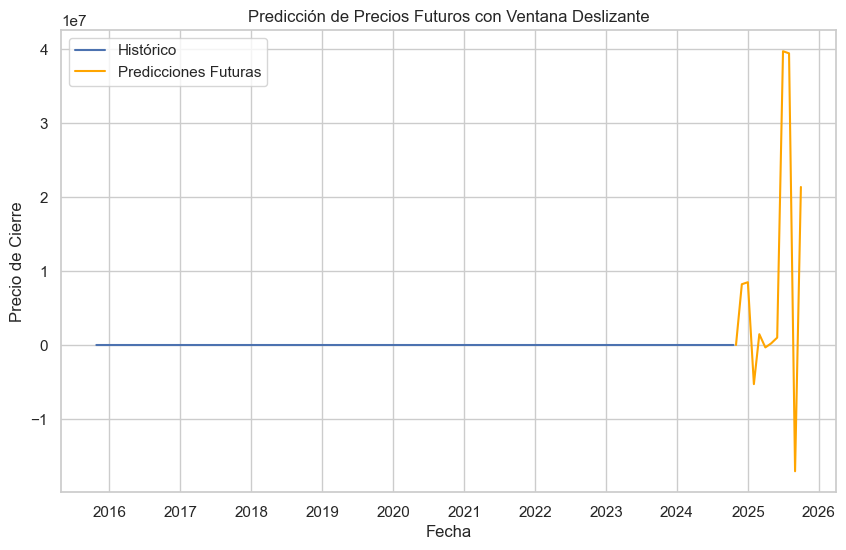

In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Crear medias móviles
def add_moving_averages(df, short_window=5, long_window=20):
    df['ma_short'] = df['close'].rolling(window=short_window).mean()
    df['ma_long'] = df['close'].rolling(window=long_window).mean()
    df.dropna(inplace=True)
    return df

# 2. Crear características con retardos y las medias móviles
def create_lagged_features(df, target, lags=5):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target].shift(lag)
    df.dropna(inplace=True)
    return df

# Aplicar medias móviles y retardos
df_lagged = apple_adjusted.copy()  # Asegúrate de tener el DataFrame 'apple_adjusted'
df_lagged = add_moving_averages(df_lagged)
df_lagged = create_lagged_features(df_lagged, 'close', lags=5)

# 3. Definir las características y el target (incluyendo medias móviles)
features = ['open', 'high', 'low', 'volume', 'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price', 'ma_short', 'ma_long']
X = df_lagged[features]
y = df_lagged['close']

# 4. Dividir en entrenamiento y prueba
split_index = int(len(df_lagged) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Entrenar el modelo de regresión lineal
model_lin_reg = LinearRegression()
model_lin_reg.fit(X_train, y_train)

# 6. Hacer predicciones
y_pred_train = model_lin_reg.predict(X_train)
y_pred_test = model_lin_reg.predict(X_test)

# Evaluar el rendimiento
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Entrenamiento - MAE: {train_mae}, RMSE: {train_rmse}")
print(f"Prueba - MAE: {test_mae}, RMSE: {test_rmse}")

# 7. Predicción futura con ventana deslizante
def predict_with_rolling_window(model, X_test, n_predictions=12):
    last_window = X_test.iloc[-1].values
    future_predictions = []
    
    for i in range(n_predictions):
        # Predicción con características con nombre
        last_window_df = pd.DataFrame([last_window], columns=X_test.columns)
        pred = model.predict(last_window_df)[0]
        future_predictions.append(pred)
        
        # Actualizar la ventana deslizante
        last_window = np.roll(last_window, -1)  # Desplazamos todas las columnas hacia la izquierda
        last_window[-1] = pred  # Usar la predicción como el nuevo valor para la característica 'close'
    
    return future_predictions

# Predecir los próximos 12 meses usando la ventana deslizante
future_predictions = predict_with_rolling_window(model_lin_reg, X_test, n_predictions=12)

# Crear fechas futuras evitando el FutureWarning con 'ME' (fin de mes)
future_dates = pd.date_range(start=X_test.index[-1], periods=12, freq='ME')

# Crear un DataFrame con las predicciones futuras
df_future = pd.DataFrame({'Date': future_dates, 'Predicted Close': future_predictions})

# Mostrar las predicciones futuras
print(df_future)

# 8. Gráfico de las predicciones
plt.figure(figsize=(10, 6))
plt.plot(df_lagged.index, df_lagged['close'], label='Histórico')
plt.plot(df_future['Date'], df_future['Predicted Close'], label='Predicciones Futuras', color='orange')
plt.title('Predicción de Precios Futuros con Ventana Deslizante')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()


Entrenamiento - MAE: 0.17776459203247436, RMSE: 0.29526162694271985
Prueba - MAE: 0.16420226201108917, RMSE: 0.2136182569788394
                        Date  Predicted Close
0  2024-10-31 00:00:00-04:00     5.873254e+01
1  2024-11-30 00:00:00-05:00     8.219248e+06
2  2024-12-31 00:00:00-05:00     8.492143e+06
3  2025-01-31 00:00:00-05:00    -5.289061e+06
4  2025-02-28 00:00:00-05:00     1.463552e+06
5  2025-03-31 00:00:00-04:00    -3.270675e+05
6  2025-04-30 00:00:00-04:00     2.212262e+05
7  2025-05-31 00:00:00-04:00     1.001725e+06
8  2025-06-30 00:00:00-04:00     3.972165e+07
9  2025-07-31 00:00:00-04:00     3.943924e+07
10 2025-08-31 00:00:00-04:00    -1.706975e+07
11 2025-09-30 00:00:00-04:00     2.136634e+07


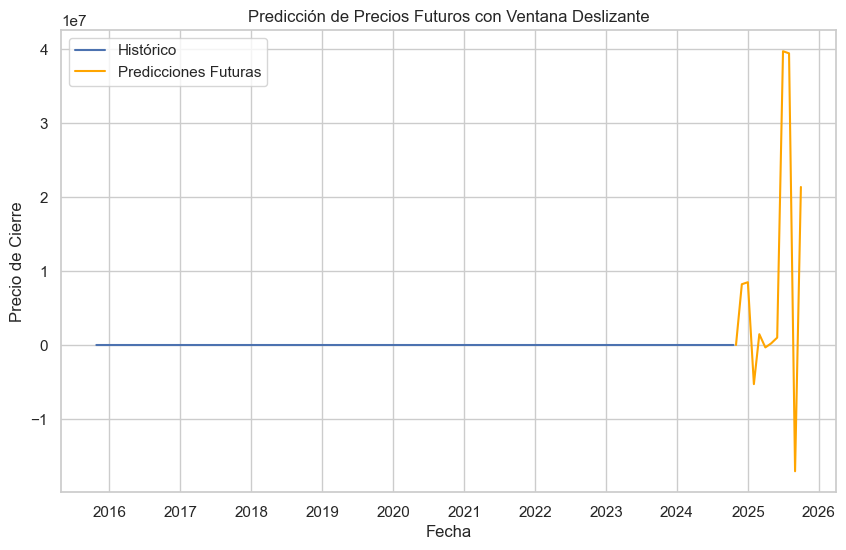

In [32]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Crear medias móviles
def add_moving_averages(df, short_window=5, long_window=20):
    df['ma_short'] = df['close'].rolling(window=short_window).mean()
    df['ma_long'] = df['close'].rolling(window=long_window).mean()
    df.dropna(inplace=True)
    return df

# 2. Crear características con retardos y las medias móviles
def create_lagged_features(df, target, lags=5):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target].shift(lag)
    df.dropna(inplace=True)
    return df

# Aplicar medias móviles y retardos
df_lagged = apple_adjusted.copy()  # Asegúrate de tener el DataFrame 'apple_adjusted'
df_lagged = add_moving_averages(df_lagged)
df_lagged = create_lagged_features(df_lagged, 'close', lags=5)

# 3. Definir las características y el target (incluyendo medias móviles)
features = ['open', 'high', 'low', 'volume', 'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price', 'ma_short', 'ma_long']
X = df_lagged[features]
y = df_lagged['close']

# 4. Dividir en entrenamiento y prueba
split_index = int(len(df_lagged) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Entrenar el modelo de regresión lineal
model_lin_reg = LinearRegression()
model_lin_reg.fit(X_train, y_train)

# 6. Hacer predicciones
y_pred_train = model_lin_reg.predict(X_train)
y_pred_test = model_lin_reg.predict(X_test)

# Evaluar el rendimiento
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Entrenamiento - MAE: {train_mae}, RMSE: {train_rmse}")
print(f"Prueba - MAE: {test_mae}, RMSE: {test_rmse}")

# 7. Predicción futura con ventana deslizante
def predict_with_rolling_window(model, X_test, n_predictions=12):
    last_window = X_test.iloc[-1].values
    future_predictions = []
    
    for i in range(n_predictions):
        # Predicción con características con nombre
        last_window_df = pd.DataFrame([last_window], columns=X_test.columns)
        pred = model.predict(last_window_df)[0]
        future_predictions.append(pred)
        
        # Actualizar la ventana deslizante
        last_window = np.roll(last_window, -1)  # Desplazamos todas las columnas hacia la izquierda
        last_window[-1] = pred  # Usar la predicción como el nuevo valor para la característica 'close'
    
    return future_predictions

# Predecir los próximos 12 meses usando la ventana deslizante
future_predictions = predict_with_rolling_window(model_lin_reg, X_test, n_predictions=12)

# Crear fechas futuras evitando el FutureWarning con 'ME' (fin de mes)
future_dates = pd.date_range(start=X_test.index[-1], periods=12, freq='ME')

# Crear un DataFrame con las predicciones futuras
df_future = pd.DataFrame({'Date': future_dates, 'Predicted Close': future_predictions})

# Mostrar las predicciones futuras
print(df_future)

# 8. Gráfico de las predicciones
plt.figure(figsize=(10, 6))
plt.plot(df_lagged.index, df_lagged['close'], label='Histórico')
plt.plot(df_future['Date'], df_future['Predicted Close'], label='Predicciones Futuras', color='orange')
plt.title('Predicción de Precios Futuros con Ventana Deslizante')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()


In [33]:
apple_adjusted.columns

Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
       'date', 'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price',
       'dividend_return', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'],
      dtype='object')

In [34]:
# Asegúrate de que la columna de fechas esté en formato de índice y tenga una frecuencia establecida
apple_adjusted['date'] = pd.to_datetime(apple_adjusted['date'])  # Asegúrate de que la columna sea tipo datetime
apple_adjusted.set_index('date', inplace=True)       # Establecer la columna de fechas como índice

# Ahora establecer la frecuencia de las fechas, por ejemplo, 'M' para datos mensuales
df = apple_adjusted.asfreq('ME')  # O asfreq('D') para datos diarios

# Si tienes datos mensuales, usa 'M', si son diarios, usa 'D', ajusta según sea necesario


In [35]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
       'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price',
       'dividend_return', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'],
      dtype='object')

In [36]:
apple_adjusted.columns

Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
       'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price',
       'dividend_return', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'],
      dtype='object')

In [37]:
apple_adjusted['date'] = apple_adjusted.index

In [38]:
# Si las fechas están en el índice, puedes crear una columna desde el índice
df['date'] = df.index


In [39]:
print(df.isnull().sum())  # Verificar si hay valores nulos
print(df.index)  # Verificar si las fechas están completas
#Eliminar nulos

df.dropna(inplace=True)


open               32
high               32
low                32
close              32
volume             32
dividends          32
stock_splits       32
log_return         32
volatility         32
ma50               32
ma100              32
volume_to_price    32
dividend_return    32
lag_1              32
lag_2              32
lag_3              32
lag_4              32
lag_5              32
date                0
dtype: int64
DatetimeIndex(['2015-09-30 00:00:00-04:00', '2015-10-31 00:00:00-04:00',
               '2015-11-30 00:00:00-05:00', '2015-12-31 00:00:00-05:00',
               '2016-01-31 00:00:00-05:00', '2016-02-29 00:00:00-05:00',
               '2016-03-31 00:00:00-04:00', '2016-04-30 00:00:00-04:00',
               '2016-05-31 00:00:00-04:00', '2016-06-30 00:00:00-04:00',
               ...
               '2023-12-31 00:00:00-05:00', '2024-01-31 00:00:00-05:00',
               '2024-02-29 00:00:00-05:00', '2024-03-31 00:00:00-04:00',
               '2024-04-30 00:00:00-04:

In [40]:
df = df.asfreq('ME')  # Reemplaza las fechas faltantes por NaN y ajusta la frecuencia mensual
df['close'] = df['close'].interpolate()  # Interpolación lineal de los valores faltantes


Epoch 1/50


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0146 - val_loss: 2.8725e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0039 - val_loss: 2.3196e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0024 - val_loss: 1.5746e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 3.8259e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021 - val_loss: 2.1093e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0037 - val_loss: 2.4515e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0028 - val_loss: 1.7397e-04
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015 - val_loss: 4.2541e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0018 - val_loss: 2.6502e-04
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━

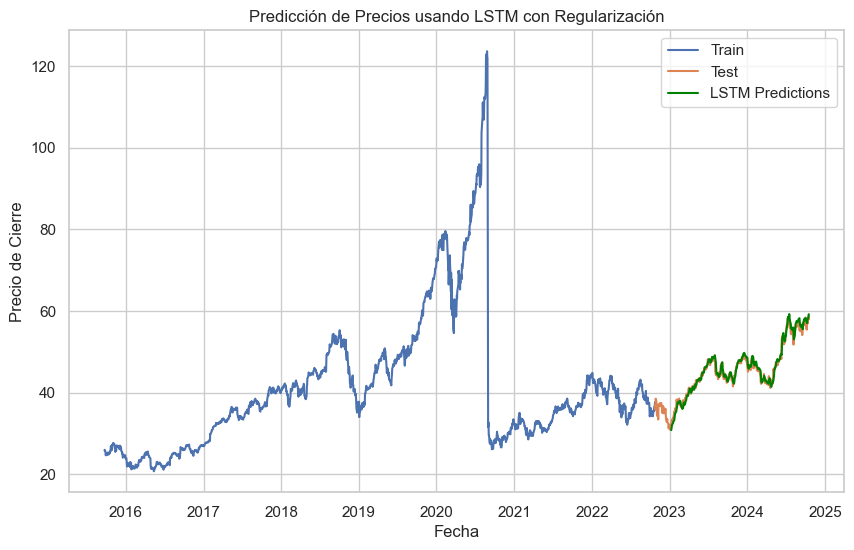

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(apple_adjusted[['close']])

# Preparar datos para LSTM
def create_dataset(dataset, time_step=50):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana de tiempo
time_step = 50
X, y = create_dataset(scaled_data, time_step)

# Redimensionar los datos para que tengan la forma esperada por LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir los datos en entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construcción del modelo LSTM con regularización
model_lstm = Sequential()

# Primera capa LSTM con dropout
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(Dropout(0.2))  # Dropout del 20%

# Segunda capa LSTM
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))

# Capa densa de salida
model_lstm.add(Dense(1))

# Compilación del modelo
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo LSTM
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predicciones con el modelo entrenado
pred_lstm = model_lstm.predict(X_test)

# Invertir el escalado de las predicciones
pred_lstm = scaler.inverse_transform(pred_lstm.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Verificar que las longitudes coincidan para evitar errores en la visualización
# Ajustar predicciones si es necesario
min_len = min(len(pred_lstm), len(apple_adjusted.index[train_size + time_step:]))
pred_lstm = pred_lstm[:min_len]
x_dates = apple_adjusted.index[train_size + time_step:train_size + time_step + min_len]

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(apple_adjusted.index[:train_size], apple_adjusted['close'][:train_size], label='Train')
plt.plot(apple_adjusted.index[train_size:], apple_adjusted['close'][train_size:], label='Test')
plt.plot(x_dates, pred_lstm, label='LSTM Predictions', color='green')
plt.title('Predicción de Precios usando LSTM con Regularización')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()


Epoch 1/50


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0185 - val_loss: 6.1467e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0050 - val_loss: 2.0081e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0044 - val_loss: 1.6609e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0033 - val_loss: 1.9215e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021 - val_loss: 1.7214e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0021 - val_loss: 1.9559e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0023 - val_loss: 4.1956e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0020 - val_loss: 1.2618e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - val_loss: 1.2017e-04
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 1.6697e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0029 - val_loss: 2.4906e-04
Epoch 12/50
56/56 ━━━━━━━━━━━━

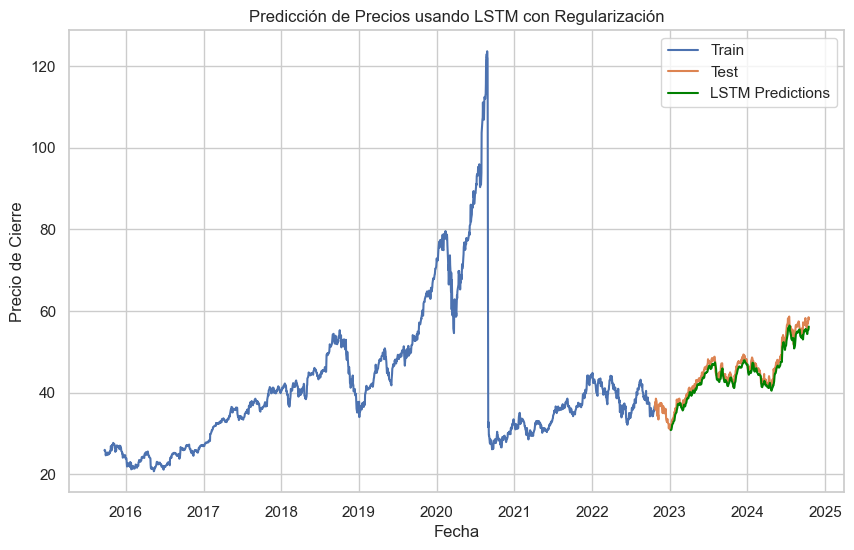

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

C:\Users\danny\AppData\Local\Temp\ipykernel_27256\369726071.py:102: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=apple_adjusted.index[-1], periods=future_months, freq='M')


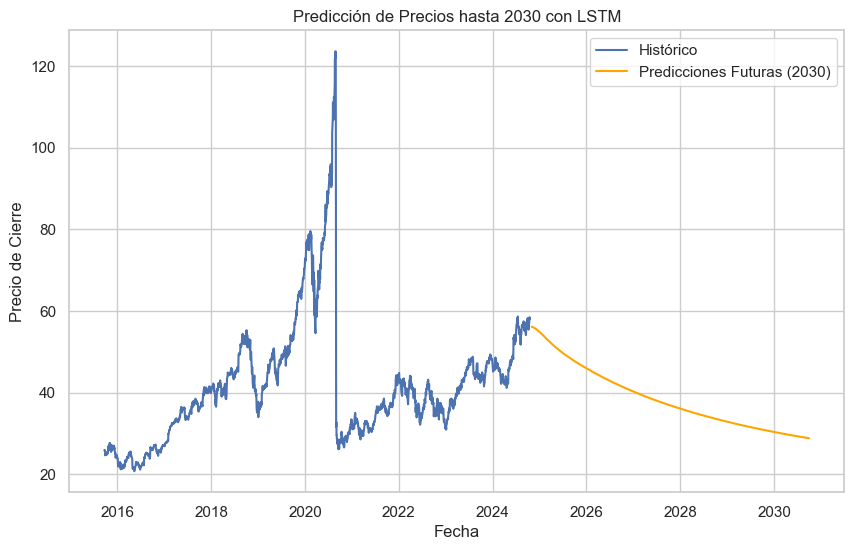

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(apple_adjusted[['close']])

# Preparar datos para LSTM
def create_dataset(dataset, time_step=50):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana de tiempo
time_step = 50
X, y = create_dataset(scaled_data, time_step)

# Redimensionar los datos para que tengan la forma esperada por LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir los datos en entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construcción del modelo LSTM con regularización
model_lstm = Sequential()

# Primera capa LSTM con dropout
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(Dropout(0.2))  # Dropout del 20%

# Segunda capa LSTM
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))

# Capa densa de salida
model_lstm.add(Dense(1))

# Compilación del modelo
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo LSTM
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predicciones con el modelo entrenado
pred_lstm = model_lstm.predict(X_test)

# Invertir el escalado de las predicciones
pred_lstm = scaler.inverse_transform(pred_lstm.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Verificar que las longitudes coincidan para evitar errores en la visualización
min_len = min(len(pred_lstm), len(apple_adjusted.index[train_size + time_step:]))
pred_lstm = pred_lstm[:min_len]
x_dates = apple_adjusted.index[train_size + time_step:train_size + time_step + min_len]

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(apple_adjusted.index[:train_size], apple_adjusted['close'][:train_size], label='Train')
plt.plot(apple_adjusted.index[train_size:], apple_adjusted['close'][train_size:], label='Test')
plt.plot(x_dates, pred_lstm, label='LSTM Predictions', color='green')
plt.title('Predicción de Precios usando LSTM con Regularización')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

# ---------------------- #
# PREDICCIÓN FUTURA HASTA 2030
# ---------------------- #

# Vamos a predecir los próximos meses hasta 2030. Vamos a asumir 72 meses (6 años).
future_months = 72  # Para predecir los próximos 6 años

# Iniciamos con la última ventana de datos de prueba
last_window = X_test[-1]

# Lista para almacenar las predicciones futuras
future_predictions = []

for _ in range(future_months):
    # Hacer una predicción para el próximo mes
    next_pred = model_lstm.predict(last_window.reshape(1, time_step, 1))
    
    # Guardar la predicción
    future_predictions.append(next_pred[0, 0])
    
    # Actualizar la ventana deslizante con la nueva predicción
    last_window = np.append(last_window[1:], next_pred, axis=0)

# Invertir el escalado de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Crear un rango de fechas futuras para las predicciones
future_dates = pd.date_range(start=apple_adjusted.index[-1], periods=future_months, freq='M')

# Graficar las predicciones futuras junto con los datos históricos
plt.figure(figsize=(10, 6))
plt.plot(apple_adjusted.index, apple_adjusted['close'], label='Histórico')
plt.plot(future_dates, future_predictions, label='Predicciones Futuras (2030)', color='orange')
plt.title('Predicción de Precios hasta 2030 con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()


### hiperparametros

Epoch 1/50


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0194 - val_loss: 2.9850e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0022 - val_loss: 2.0187e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0024 - val_loss: 9.9794e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034 - val_loss: 1.5431e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022 - val_loss: 1.4532e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0016 - val_loss: 1.5381e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020 - val_loss: 1.6721e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022 - val_loss: 2.7373e-04
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019 - val_loss: 1.1039e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017 - val_loss: 1.3505e-04
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━

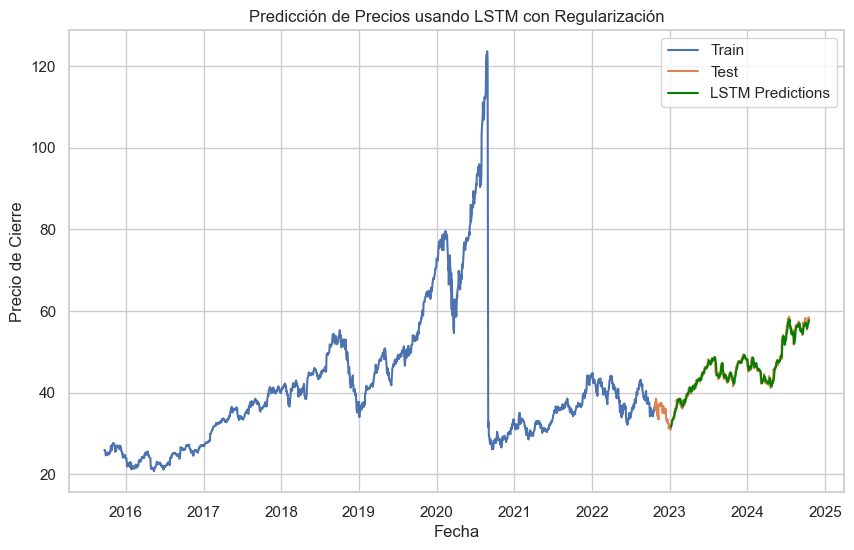

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Users\danny\AppData\Local\Temp\ipykernel_27256\1367169337.py:102: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=apple_adjusted.index[-1], periods=future_months, freq='M')


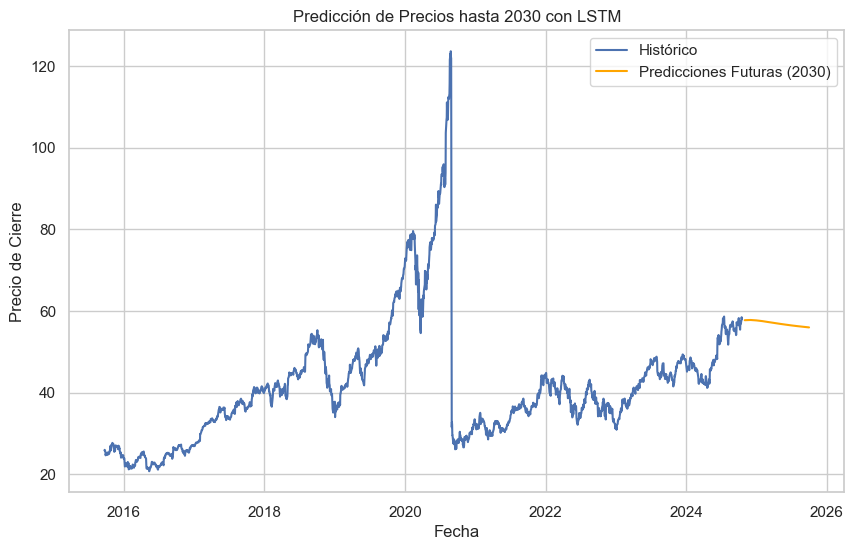

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(apple_adjusted[['close']])

# Preparar datos para LSTM
def create_dataset(dataset, time_step=50):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana de tiempo
time_step = 50
X, y = create_dataset(scaled_data, time_step)

# Redimensionar los datos para que tengan la forma esperada por LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir los datos en entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construcción del modelo LSTM con regularización
model_lstm = Sequential()

# Primera capa LSTM con dropout
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(Dropout(0.2))  # Dropout del 20%

# Segunda capa LSTM
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))

# Capa densa de salida
model_lstm.add(Dense(1))

# Compilación del modelo
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo LSTM
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predicciones con el modelo entrenado
pred_lstm = model_lstm.predict(X_test)

# Invertir el escalado de las predicciones
pred_lstm = scaler.inverse_transform(pred_lstm.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Verificar que las longitudes coincidan para evitar errores en la visualización
min_len = min(len(pred_lstm), len(apple_adjusted.index[train_size + time_step:]))
pred_lstm = pred_lstm[:min_len]
x_dates = apple_adjusted.index[train_size + time_step:train_size + time_step + min_len]

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(apple_adjusted.index[:train_size], apple_adjusted['close'][:train_size], label='Train')
plt.plot(apple_adjusted.index[train_size:], apple_adjusted['close'][train_size:], label='Test')
plt.plot(x_dates, pred_lstm, label='LSTM Predictions', color='green')
plt.title('Predicción de Precios usando LSTM con Regularización')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

# ---------------------- #
# PREDICCIÓN FUTURA HASTA 2030
# ---------------------- #

# Vamos a predecir los próximos meses hasta 2030. Vamos a asumir 72 meses (6 años).
future_months = 12  # Para predecir los próximos 6 años

# Iniciamos con la última ventana de datos de prueba
last_window = X_test[-1]

# Lista para almacenar las predicciones futuras
future_predictions = []

for _ in range(future_months):
    # Hacer una predicción para el próximo mes
    next_pred = model_lstm.predict(last_window.reshape(1, time_step, 1))
    
    # Guardar la predicción
    future_predictions.append(next_pred[0, 0])
    
    # Actualizar la ventana deslizante con la nueva predicción
    last_window = np.append(last_window[1:], next_pred, axis=0)

# Invertir el escalado de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Crear un rango de fechas futuras para las predicciones
future_dates = pd.date_range(start=apple_adjusted.index[-1], periods=future_months, freq='M')

# Graficar las predicciones futuras junto con los datos históricos
plt.figure(figsize=(10, 6))
plt.plot(apple_adjusted.index, apple_adjusted['close'], label='Histórico')
plt.plot(future_dates, future_predictions, label='Predicciones Futuras (2030)', color='orange')
plt.title('Predicción de Precios hasta 2030 con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()


Root Mean Squared Error (RMSE) en el conjunto de prueba: 0.8084616851912935
Mean Absolute Error (MAE) en el conjunto de prueba: 0.6183128911643487


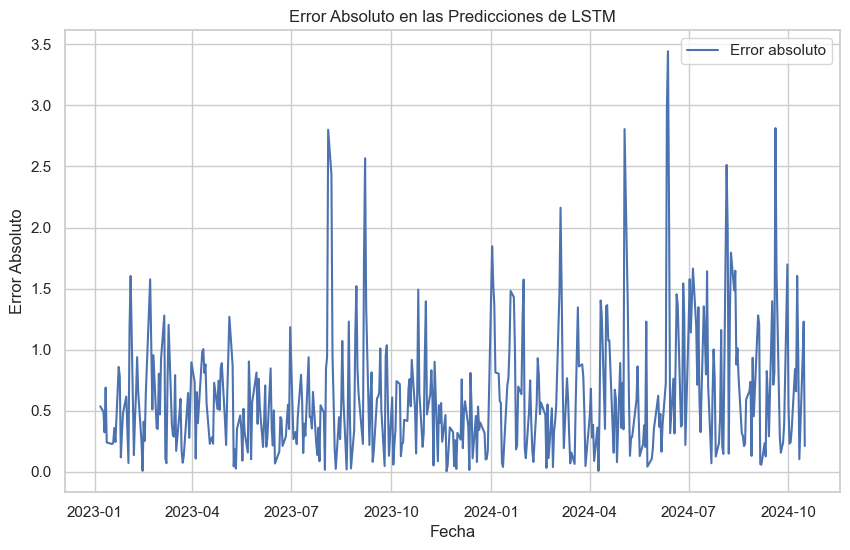

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calcular RMSE y MAE en las predicciones
rmse = np.sqrt(mean_squared_error(y_test, pred_lstm))
mae = mean_absolute_error(y_test, pred_lstm)

print(f"Root Mean Squared Error (RMSE) en el conjunto de prueba: {rmse}")
print(f"Mean Absolute Error (MAE) en el conjunto de prueba: {mae}")

# Para observar cómo el error podría acumularse con el tiempo, podrías graficar
# el error para diferentes horizontes de predicción. Una opción simple es ver
# cómo cambia el error con el tiempo en el conjunto de prueba.
errors = np.abs(pred_lstm - y_test)

plt.figure(figsize=(10, 6))
plt.plot(apple_adjusted.index[train_size + time_step:train_size + time_step + min_len], errors, label='Error absoluto')
plt.title('Error Absoluto en las Predicciones de LSTM')
plt.xlabel('Fecha')
plt.ylabel('Error Absoluto')
plt.legend()
plt.show()


Modelos híbridos: Combinación de LSTM y SARIMA

In [54]:
print(df.index.freq)  # Esto debería devolver 'M' para mensual, 'D' para diario, etc.


<MonthEnd>


In [61]:
print(df.columns)


Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
       'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price',
       'dividend_return', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'],
      dtype='object')


In [69]:
print(df.index)


DatetimeIndex(['2015-09-30 00:00:00-04:00',                       'NaT',
               '2015-11-30 00:00:00-05:00', '2015-12-31 00:00:00-05:00',
                                     'NaT', '2016-02-29 00:00:00-05:00',
               '2016-03-31 00:00:00-04:00',                       'NaT',
               '2016-05-31 00:00:00-04:00', '2016-06-30 00:00:00-04:00',
               ...
                                     'NaT', '2024-01-31 00:00:00-05:00',
               '2024-02-29 00:00:00-05:00',                       'NaT',
               '2024-04-30 00:00:00-04:00', '2024-05-31 00:00:00-04:00',
                                     'NaT', '2024-07-31 00:00:00-04:00',
                                     'NaT', '2024-09-30 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='date', length=109, freq=None)


In [72]:
# Eliminar duplicados en el índice
df = df.loc[~df.index.duplicated(keep='first')]

# Luego, establecer la frecuencia mensual
df = df.asfreq('ME')  # Establece frecuencia de fin de mes



In [74]:
import pandas as pd
import statsmodels.api as sm

# Asegurar que el índice ya es de tipo datetime, por si acaso
df.index = pd.to_datetime(df.index)

# Asignar la frecuencia mensual (M para mensual, que implica fin de mes)
df = df.asfreq('ME')

# Ahora puedes usar el DataFrame con SARIMA
sarima_model = sm.tsa.SARIMAX(df['close'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_results = sarima_model.fit()

# Hacer predicciones o evaluar el modelo
forecast = sarima_results.forecast(steps=12)
print(forecast)



c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


2024-10-31 00:00:00-04:00    59.355061
2024-11-30 00:00:00-05:00    60.289739
2024-12-31 00:00:00-05:00    60.337063
2025-01-31 00:00:00-05:00    60.784613
2025-02-28 00:00:00-05:00    60.244083
2025-03-31 00:00:00-04:00    60.246511
2025-04-30 00:00:00-04:00    60.914733
2025-05-31 00:00:00-04:00    63.235203
2025-06-30 00:00:00-04:00    64.057517
2025-07-31 00:00:00-04:00    71.683698
2025-08-31 00:00:00-04:00    62.398819
2025-09-30 00:00:00-04:00    63.831373
Freq: ME, Name: predicted_mean, dtype: float64


In [78]:
# Rellenar valores faltantes usando interpolación
df['close'] = df['close'].interpolate(method='linear')

# O puedes usar el último valor conocido para rellenar:
# df['close'] = df['close'].fillna(method='ffill')


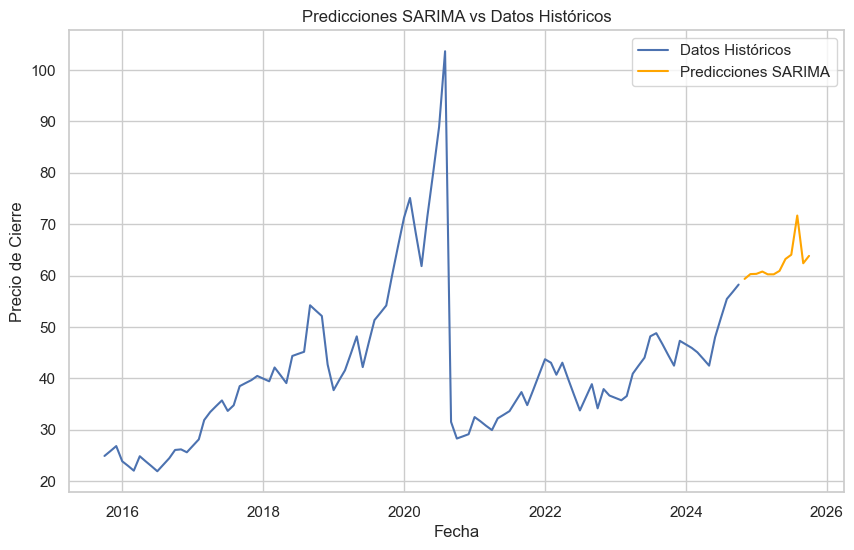

In [79]:
import matplotlib.pyplot as plt

# Graficar los datos históricos y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['close'], label='Datos Históricos')
plt.plot(forecast.index, forecast, label='Predicciones SARIMA', color='orange')
plt.title('Predicciones SARIMA vs Datos Históricos')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()


Modelos avanzados: Usar GRU en lugar de LSTM

Epoch 1/50


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0194 - val_loss: 6.2052e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0019 - val_loss: 9.0628e-05
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0016 - val_loss: 8.3090e-05
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0015 - val_loss: 2.3724e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0014 - val_loss: 8.3721e-05
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0010 - val_loss: 6.7615e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0014 - val_loss: 1.5143e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0012 - val_loss: 1.7007e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0020 - val_loss: 9.0204e-05
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 8.8011e-04 - val_loss: 4.3141e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0012 - val_loss: 1.3566e-04
Epoch 12/50
56/56 ━━━━━━━━

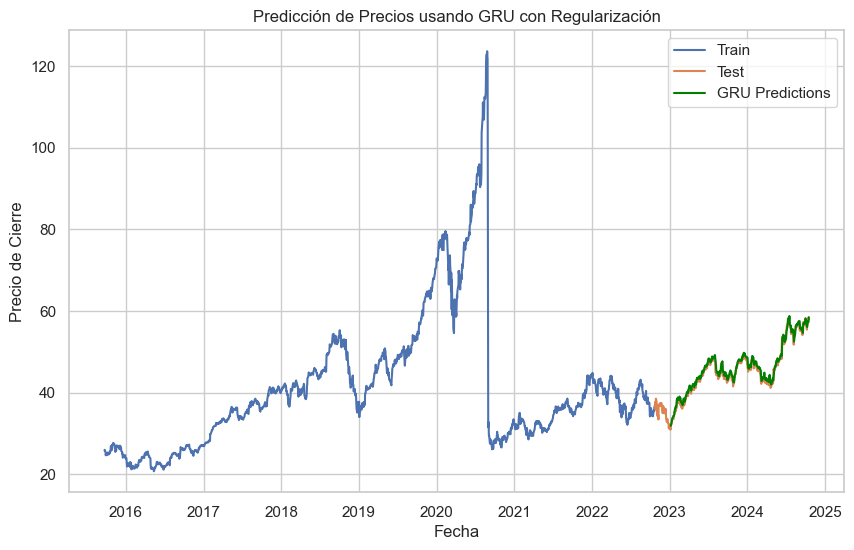

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(apple_adjusted[['close']])

# Preparar datos para GRU
def create_dataset(dataset, time_step=50):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana de tiempo
time_step = 50
X, y = create_dataset(scaled_data, time_step)

# Redimensionar los datos para que tengan la forma esperada por GRU
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir los datos en entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construcción del modelo GRU con regularización
model_gru = Sequential()

# Primera capa GRU con dropout
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_gru.add(Dropout(0.2))  # Dropout del 20%

# Segunda capa GRU
model_gru.add(GRU(units=50, return_sequences=False))
model_gru.add(Dropout(0.2))

# Capa densa de salida
model_gru.add(Dense(1))

# Compilación del modelo
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo GRU
history = model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predicciones con el modelo entrenado
pred_gru = model_gru.predict(X_test)

# Invertir el escalado de las predicciones
pred_gru = scaler.inverse_transform(pred_gru.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Verificar que las longitudes coincidan para evitar errores en la visualización
min_len = min(len(pred_gru), len(apple_adjusted.index[train_size + time_step:]))
pred_gru = pred_gru[:min_len]
x_dates = apple_adjusted.index[train_size + time_step:train_size + time_step + min_len]

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(apple_adjusted.index[:train_size], apple_adjusted['close'][:train_size], label='Train')
plt.plot(apple_adjusted.index[train_size:], apple_adjusted['close'][train_size:], label='Test')
plt.plot(x_dates, pred_gru, label='GRU Predictions', color='green')
plt.title('Predicción de Precios usando GRU con Regularización')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()



Epoch 1/50


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0151 - val_loss: 9.9548e-05
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0022 - val_loss: 5.7788e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0028 - val_loss: 2.6737e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0014 - val_loss: 7.6451e-05
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0016 - val_loss: 5.7822e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0021 - val_loss: 6.3098e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0012 - val_loss: 6.7837e-05
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.4870e-04 - val_loss: 6.5984e-05
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 8.2776e-04 - val_loss: 3.6252e-04
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011 - val_loss: 1.5117e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0013 - val_loss: 6.4388e-05
Epoch 12/50
56/56 ━━━━

C:\Users\danny\AppData\Local\Temp\ipykernel_27256\149016730.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date, periods=n_future_steps, freq='M')


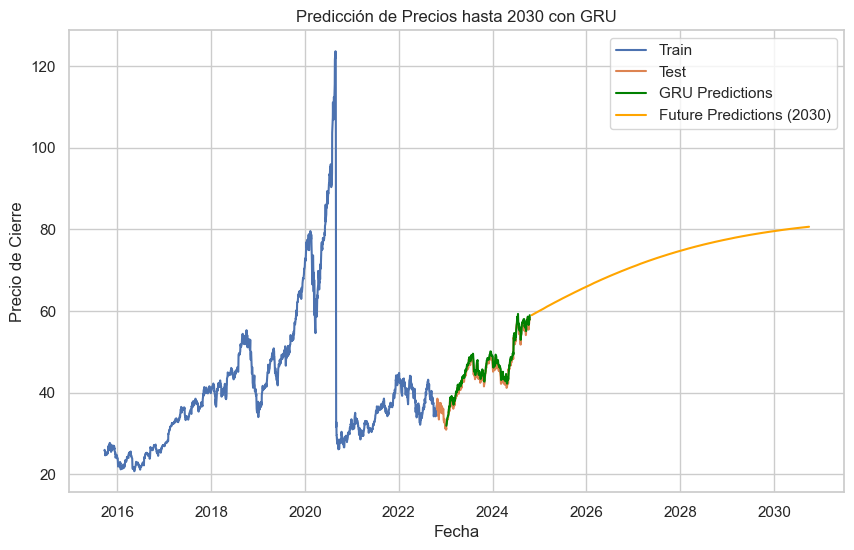

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(apple_adjusted[['close']])

# Preparar datos para GRU
def create_dataset(dataset, time_step=50):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana de tiempo
time_step = 50
X, y = create_dataset(scaled_data, time_step)

# Redimensionar los datos para que tengan la forma esperada por GRU
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir los datos en entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construcción del modelo GRU con regularización
model_gru = Sequential()

# Primera capa GRU con Dropout
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_gru.add(Dropout(0.2))

# Segunda capa GRU
model_gru.add(GRU(units=50, return_sequences=False))
model_gru.add(Dropout(0.2))

# Capa densa de salida
model_gru.add(Dense(1))

# Compilación del modelo
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo GRU
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predicciones con el modelo entrenado
pred_gru = model_gru.predict(X_test)

# Invertir el escalado de las predicciones
pred_gru = scaler.inverse_transform(pred_gru.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Asegurarnos de que la longitud de las predicciones y las fechas coincidan
min_len = min(len(pred_gru), len(apple_adjusted.index[train_size + time_step:]))
pred_gru = pred_gru[:min_len]
x_dates = apple_adjusted.index[train_size + time_step:train_size + time_step + min_len]

# Predicción iterativa para hasta 2030
last_window = X_test[-1]  # Última ventana
n_future_steps = (2030 - 2024) * 12  # Predicción mensual hasta 2030

future_predictions = []
for _ in range(n_future_steps):
    next_pred = model_gru.predict(last_window.reshape(1, time_step, 1))
    future_predictions.append(next_pred[0, 0])
    last_window = np.append(last_window[1:], next_pred[0, 0]).reshape(time_step, 1)

# Invertir el escalado de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Crear un índice de fechas para las predicciones futuras
last_date = apple_adjusted.index[-1]
future_dates = pd.date_range(last_date, periods=n_future_steps, freq='M')

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(apple_adjusted.index[:train_size], apple_adjusted['close'][:train_size], label='Train')
plt.plot(apple_adjusted.index[train_size:], apple_adjusted['close'][train_size:], label='Test')
plt.plot(x_dates, pred_gru, label='GRU Predictions', color='green')
plt.plot(future_dates, future_predictions, label='Future Predictions (2030)', color='orange')
plt.title('Predicción de Precios hasta 2030 con GRU')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(apple_adjusted[['close']])

# Preparar datos para GRU
def create_dataset(dataset, time_step=50):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 50
X, y = create_dataset(scaled_data, time_step)

# Redimensionar los datos para que tengan la forma esperada por GRU
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir los datos en entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construcción del modelo GRU con regularización
model_gru = Sequential()

# Primera capa GRU con dropout
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_gru.add(Dropout(0.2))  # Dropout del 20%

# Segunda capa GRU
model_gru.add(GRU(units=50, return_sequences=False))
model_gru.add(Dropout(0.2))

# Capa densa de salida
model_gru.add(Dense(1))

# Compilación del modelo
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo GRU
history = model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predicciones con el modelo entrenado
pred_gru = model_gru.predict(X_test)

# Invertir el escalado de las predicciones
pred_gru = scaler.inverse_transform(pred_gru.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Modelo SARIMA para combinación híbrida
sarima_model = sm.tsa.SARIMAX(apple_adjusted['close'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_results = sarima_model.fit()

# Predicciones del SARIMA
sarima_pred = sarima_results.predict(start=train_size + time_step, end=train_size + time_step + len(pred_gru) - 1)

# Ajustar predicciones si es necesario para evitar desajustes de longitud
min_len = min(len(pred_gru), len(sarima_pred))

# Ajustar tanto las predicciones GRU como las de SARIMA para que tengan la misma longitud
pred_gru = pred_gru[:min_len]
sarima_pred_adjusted = sarima_pred[:min_len]

# Hacer la predicción híbrida sumando las predicciones del modelo GRU y del SARIMA
pred_hybrid = pred_gru.flatten() + sarima_pred_adjusted

# Asegurarte de que las longitudes coincidan para evitar errores en la visualización
min_len = min(len(pred_hybrid), len(apple_adjusted.index[train_size + time_step:]))

# Ajustar tanto las fechas como las predicciones para que tengan la misma longitud
x_dates = apple_adjusted.index[train_size + time_step:train_size + time_step + min_len]

# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.plot(apple_adjusted.index[:train_size], apple_adjusted['close'][:train_size], label='Train')
plt.plot(apple_adjusted.index[train_size:], apple_adjusted['close'][train_size:], label='Test')
plt.plot(x_dates, pred_hybrid, label='Hybrid Predictions', color='green')
plt.title('Predicción de Precios usando Modelo Híbrido (SARIMA + GRU)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()


NameError: name 'apple_adjusted' is not defined